In [3]:
import pandas as pd
import numpy as np
from typing import Any
from tqdm import tqdm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import odr
from scipy.stats import median_abs_deviation
import pickle
import os
import time
import seaborn as sns
sns.set_theme()

from utils import *

import matplotlib.pyplot as plt

LEVEL = 'member'  # 'member' or 'client'
N = 1
RECOMPUTE = True

column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}


### Intro

Now I start to preprocess the dataframes

In [2]:
PATH_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT"
PATH_NEW_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW"

if os.path.exists(PATH_NEW_DATA_FOLDER) is False:
    os.mkdir(PATH_NEW_DATA_FOLDER)

dfs_paths = [PATH_DATA_FOLDER + '/' + path for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
isins = [path.split('.')[0] for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
print(dfs_paths)
print(isins)

['C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000062072.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000062957.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000066123.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000072170.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000072618.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000784196.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001078911.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001157020.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001233417.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001250932.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001347308.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003128367.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003132476.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003153415.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003242622.

One of the original data sets

In [3]:
# df = pd.read_csv(dfs_paths[1], sep=';')
# df

Transform the original datasets

In [4]:
# for path in dfs_paths:
#     new_path = PATH_NEW_DATA_FOLDER + '/' + os.path.basename(path).split('.')[0] + '.parquet'
#     if os.path.exists(new_path):
#         print(f"Transformed file for {new_path} already exists. Skipping...")
#         continue
#     print(f"Processing {path}...")
#     df = pd.read_csv(path, sep=';')
#     df_mapped = map_trade_codes(df)
#     df_transformed = build_trades_view(df_mapped)
#     if len(df_transformed[(df_transformed['Total Quantity Buy'] > 0) & (df_transformed['Total Quantity Sell'] > 0)]) > 0:
#         print(f"Warning: Both Buy and Sell quantities greater than zero found in {path}. Check data integrity.")
#     # display(df_transformed)
#     df_transformed.to_parquet(new_path)
#     print(f"Saved transformed data to {new_path}.")

One of te new dataset

In [5]:
# df = pd.read_parquet('C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062072.parquet')
# df

In [6]:
dfs_path_new = [PATH_NEW_DATA_FOLDER + '/' + path for path in os.listdir(PATH_NEW_DATA_FOLDER) if (path.endswith('.parquet'))]
dfs_path_new

['C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062072.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062957.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000066123.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000072170.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000072618.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000784196.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001078911.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001157020.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001233417.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001250932.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001347308.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0003128367.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0003132476.parquet',
 'C:/Users/U

In [7]:
# random_path = np.random.choice(dfs_path_new)
# df = pd.read_parquet(random_path)
# if len(df[(df['Total Quantity Buy'] > 0) & (df['Total Quantity Sell'] > 0)]) > 0:
#         print(f"Warning: Both Buy and Sell quantities greater than zero found in {random_path}. Check data integrity.")


### Metaorder computation

In this cell I compute the time series of the metaorders (consecutive trades of the same sign, performed by the same broker for the same client). I use here only trades not made as proprietary trades. The metaorders are evaluated wrt the broker here.

In [8]:
if os.path.exists(f'out_files/metaorders_dict_all_nofilter_{LEVEL}.pkl') and RECOMPUTE==False:
    print(f"Loading metaorders_dict_all_nofilter_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_{LEVEL}.pkl')
    print('Done.')
else:
    metaorders_dict_all = {isin:{} for isin in isins}
    for i, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        trades_members_numpy = trades_members.to_numpy()

        # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
        column_positions = {'Trade Time': 3, 'ID Member': 1, 'ID Client': 0, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8}
        print('    Evaluating agents activity...')
        # agents_dict, _, _, _ = agents_activity(trades_members_numpy, column_positions, level=LEVEL)
        indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
        print('    Done.')

        # ---------- Reusable dense buffer aligned to all trades ----------
        n_trades = len(trades_members_numpy)
        act_dense = np.zeros(n_trades, dtype=np.int8)

        # ---------- Per-agent metaorders ----------
        for aid in tqdm(indices_by_agent.keys(), desc="    Processing agents"):
            idxs = indices_by_agent[aid]
            signs = act_by_agent[aid]

            if idxs.size == 0:
                continue

            # Fill only the touched locations; rest remains zero
            act_dense[idxs] = signs

            # Find metaorders (constant sign runs in the reduced sequence)
            _, metaorders_original_indexes, n_metaorders = find_metaorders(act_dense, min_child=2)
            if n_metaorders == 0:
                act_dense[idxs] = 0  # reset
                continue

            # Filter: single-child, cross-day, multi-client
            kept = []
            for meta_idx_list in metaorders_original_indexes:
                if len(meta_idx_list) < 2:
                    continue

                # Time constraint: same day
                t_start = pd.Timestamp(trades_members_numpy[meta_idx_list[0], column_positions["Trade Time"]])
                t_end   = pd.Timestamp(trades_members_numpy[meta_idx_list[-1], column_positions["Trade Time"]])
                if t_start.date() != t_end.date():
                    continue

                # Single-client constraint (redundant if level=='client', but kept for safety)
                clients = np.unique(trades_members_numpy[meta_idx_list, column_positions["ID Client"]])
                if len(clients) > 1:
                    continue

                kept.append(meta_idx_list)

            if kept:
                metaorders_dict[aid] = kept

            # Reset only the positions we set (cheap)
            act_dense[idxs] = 0

        # Save back for this ISIN
        metaorders_dict_all[isin] = metaorders_dict

        # Summary
        total_number_metaorders = sum(len(v) for v in metaorders_dict.values())
        print(f"    Total number of metaorders ({isin}): {total_number_metaorders}")

        # Free a bit
        del trades_members, trades_members_numpy, indices_by_agent, act_by_agent, act_dense
        gc.collect()

    #Save on file the metaorders_dict_all without filtering
    print(f"Saving metaorders_dict_all_nofilter_{LEVEL}.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_nofilter_{LEVEL}.pkl')
    print("Done.")


(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    273372 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 35/35 [00:00<00:00, 47.24it/s]


    Total number of metaorders (IT0000062072): 15661
(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.
    236076 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 72.13it/s]


    Total number of metaorders (IT0000062957): 16332
(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.
    448494 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:01<00:00, 36.56it/s]


    Total number of metaorders (IT0000066123): 32118
(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    206719 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 100.74it/s]


    Total number of metaorders (IT0000072170): 13422
(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.
    942290 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 45/45 [00:02<00:00, 18.72it/s]


    Total number of metaorders (IT0000072618): 64540
(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    161523 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 110.78it/s]


    Total number of metaorders (IT0000784196): 10331
(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    91216 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 44/44 [00:00<00:00, 135.11it/s]


    Total number of metaorders (IT0001078911): 7315
(8/41) Processing ISIN IT0001157020...
    Loading trades data...
   178584 trades loaded.
    Done.
    73563 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 209.71it/s]


    Total number of metaorders (IT0001157020): 4937
(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.
    142656 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 118.77it/s]


    Total number of metaorders (IT0001233417): 10507
(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.
    77643 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 293.35it/s]


    Total number of metaorders (IT0001250932): 5985
(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.
    114063 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 174.63it/s]


    Total number of metaorders (IT0001347308): 8820
(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.
    676692 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:01<00:00, 25.45it/s]


    Total number of metaorders (IT0003128367): 45014
(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.
    702874 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 45/45 [00:01<00:00, 28.21it/s]


    Total number of metaorders (IT0003132476): 41800
(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.
    193447 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 93.35it/s]


    Total number of metaorders (IT0003153415): 13810
(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.
    165369 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


    Total number of metaorders (IT0003242622): 11911
(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    138355 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 149.90it/s]


    Total number of metaorders (IT0003261697): 9391
(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    109270 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 181.74it/s]


    Total number of metaorders (IT0003492391): 9379
(18/41) Processing ISIN IT0003497168...
    Loading trades data...
   958007 trades loaded.
    Done.
    455726 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:01<00:00, 39.20it/s]


    Total number of metaorders (IT0003497168): 29168
(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    167525 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:00<00:00, 111.10it/s]


    Total number of metaorders (IT0003796171): 11967
(20/41) Processing ISIN IT0003828271...
    Loading trades data...
   194343 trades loaded.
    Done.
    68843 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 262.89it/s]

    Total number of metaorders (IT0003828271): 5197


(21/41) Processing ISIN IT0003856405...
    Loading trades data...
   1301869 trades loaded.
    Done.
    534570 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:01<00:00, 28.95it/s]


    Total number of metaorders (IT0003856405): 39317
(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.
    186841 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:00<00:00, 99.93it/s]


    Total number of metaorders (IT0004056880): 14784
(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.
    308905 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:00<00:00, 57.84it/s]


    Total number of metaorders (IT0004176001): 23955
(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    111417 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:00<00:00, 212.27it/s]


    Total number of metaorders (IT0004764699): 8844
(25/41) Processing ISIN IT0004776628...
    Loading trades data...
   219397 trades loaded.
    Done.
    92262 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 236.15it/s]


    Total number of metaorders (IT0004776628): 6883
(26/41) Processing ISIN IT0004810054...
    Loading trades data...
   318970 trades loaded.
    Done.
    132034 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 150.87it/s]


    Total number of metaorders (IT0004810054): 10385
(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.
    259138 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 45/45 [00:00<00:00, 98.51it/s] 


    Total number of metaorders (IT0004965148): 20249
(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    65412 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 401.72it/s]

    Total number of metaorders (IT0005090300): 5505
(29/41) Processing ISIN IT0005211237...
    Loading trades data...


   215627 trades loaded.
    Done.
    77765 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 224.26it/s]


    Total number of metaorders (IT0005211237): 5817
(30/41) Processing ISIN IT0005218380...
    Loading trades data...
   1031149 trades loaded.
    Done.
    435384 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:01<00:00, 38.07it/s]


    Total number of metaorders (IT0005218380): 29805
(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.
    1053860 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:02<00:00, 16.79it/s]


    Total number of metaorders (IT0005239360): 85317
(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    105291 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 208.01it/s]


    Total number of metaorders (IT0005278236): 9218
(33/41) Processing ISIN IT0005366767...
    Loading trades data...
   598903 trades loaded.
    Done.
    245033 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 79.70it/s]


    Total number of metaorders (IT0005366767): 19677
(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.
    455784 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:01<00:00, 29.32it/s]


    Total number of metaorders (IT0005495657): 27991
(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.
    557873 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:01<00:00, 33.26it/s]


    Total number of metaorders (IT0005508921): 37741
(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.
    251471 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 81.83it/s] 


    Total number of metaorders (LU2598331598): 22261
(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.
    522704 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:01<00:00, 26.56it/s]


    Total number of metaorders (NL0000226223): 35267
(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.
    432661 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:00<00:00, 45.06it/s]


    Total number of metaorders (NL0011585146): 37577
(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.
    1022295 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:02<00:00, 15.55it/s]


    Total number of metaorders (NL00150001Q9): 82740
(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.
    298743 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 67.68it/s]


    Total number of metaorders (NL0015000LU4): 22768
(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.
    347201 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 54.86it/s]


    Total number of metaorders (NL0015435975): 24503
Saving metaorders_dict_all_nofilter_member.pkl...
Done.


In [9]:
MAX_GAP = pd.Timedelta(hours=1)        # soglia di 1 h
MIN_TRADES = 2

if os.path.exists(f'out_files/metaorders_dict_all_{LEVEL}.pkl') and RECOMPUTE==False:
    print(f"Loading filtered metaorders_dict_all_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_{LEVEL}.pkl')
    print('Done')
else:
    print(f"Loading unfiltered metaorders_dict_all_nofilter_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_{LEVEL}.pkl')

    # ---- constants (nanosecond precision for intraday filter) ----
    S_NS  = np.int64(1_000_000_000)
    M_NS  = np.int64(60) * S_NS
    H_NS  = np.int64(60) * M_NS
    DAY_NS = np.int64(24) * H_NS

    START_NS = np.int64(9) * H_NS + np.int64(30) * M_NS           # 09:30:00.000
    END_NS   = np.int64(17) * H_NS + np.int64(30) * M_NS          # 17:30:00.000

    # Convert MAX_GAP to numpy timedelta64[ns] once (fast comparisons later)
    try:
        max_gap_np = MAX_GAP.to_numpy()
    except AttributeError:
        max_gap_np = np.timedelta64(int(MAX_GAP.value), 'ns')

    for i, path in enumerate(dfs_path_new):
        isin = os.path.splitext(os.path.basename(path))[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")

        # alias to avoid repeated dictionary lookups in inner loops
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        # Read only needed columns to reduce IO/memory
        trades_members = pd.read_parquet(path, columns=['Trade Time', 'Trade Type Aggressive'])
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # --- vectorized filter: exclude proprietary + keep [09:30:00, 17:30:00] EXACTLY ---
        tta = trades_members['Trade Type Aggressive'].values
        tm = trades_members['Trade Time']

        # Fast intraday nanoseconds since midnight, preserving timezone semantics:
        # If tz-naive -> use int64 view (ns since epoch) % DAY_NS
        # If tz-aware -> compute from components (hour/min/sec/micro/nano) to avoid UTC shifts
        if tm.dt.tz is None:
            # pandas 2.x: Series.view('i8') works for tz-naive datetime64[ns]
            ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
        else:
            ns_since_midnight = (
                tm.dt.hour.astype(np.int64)   * H_NS +
                tm.dt.minute.astype(np.int64) * M_NS +
                tm.dt.second.astype(np.int64) * S_NS +
                tm.dt.microsecond.astype(np.int64) * np.int64(1_000) +
                tm.dt.nanosecond.astype(np.int64)
            )

        # Inclusive bounds, matching .dt.time.between(..., inclusive='both'):
        in_hours = (ns_since_midnight >= START_NS) & (ns_since_midnight <= END_NS)
        mask = (tta != 'Dealing_on_own_account') & in_hours
        trades_members = trades_members.loc[mask].copy()

        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members.reset_index(drop=True, inplace=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)

        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # Pre-extract the numpy array of times for fast slicing
        times_arr = trades_members['Trade Time'].to_numpy()

        # ---------------------------------------------------------------------
        # loop sui broker/members: split su gap > 1h
        # ---------------------------------------------------------------------
        for member_id, meta_list in metaorders_dict.items():
            new_metaorders = []
            append_nm = new_metaorders.append

            for meta in meta_list:
                if len(meta) < 2:
                    append_nm(meta)
                    continue

                idx_arr = np.asarray(meta, dtype=np.int64)
                ts = times_arr[idx_arr]
                diffs = ts[1:] - ts[:-1]

                split_idx = np.flatnonzero(diffs > max_gap_np)
                if split_idx.size == 0:
                    parts = [idx_arr]
                else:
                    # np.split expects indices after the cut; add 1
                    parts = np.split(idx_arr, split_idx + 1)

                # aggiungi solo i segmenti di lunghezza >= MIN_TRADES
                for part in parts:
                    if part.size >= MIN_TRADES:
                        append_nm(part.tolist())

            metaorders_dict[member_id] = new_metaorders

        # --- stampa il numero totale di meta-ordini per questo btp -------------
        total_meta = sum(len(metas) for metas in metaorders_dict.values())
        print(f"{isin}: {total_meta} metaorders")

    # salva su file
    print(f"Saving filtered metaorders_dict_all_{LEVEL}.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_{LEVEL}.pkl')
    print("Done.")


Loading unfiltered metaorders_dict_all_nofilter_member.pkl...
(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    273372 trades after filtering out proprietary trades and outside trading hours.
IT0000062072: 15684 metaorders
(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    236076 trades after filtering out proprietary trades and outside trading hours.
IT0000062957: 16388 metaorders
(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    448494 trades after filtering out proprietary trades and outside trading hours.
IT0000066123: 32219 metaorders
(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    206719 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000072170: 13455 metaorders
(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    942290 trades after filtering out proprietary trades and outside trading hours.
IT0000072618: 64636 metaorders
(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    161523 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000784196: 10288 metaorders
(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    91216 trades after filtering out proprietary trades and outside trading hours.
IT0001078911: 7297 metaorders
(8/41) Processing ISIN IT0001157020...
    Loading trades data...
   178584 trades loaded.
    Done.
    73563 trades after filtering out proprietary trades and outside trading hours.
IT0001157020: 4916 metaorders
(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    142656 trades after filtering out proprietary trades and outside trading hours.
IT0001233417: 10486 metaorders
(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.
    77643 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0001250932: 6002 metaorders
(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.
    114063 trades after filtering out proprietary trades and outside trading hours.
IT0001347308: 8899 metaorders
(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    676692 trades after filtering out proprietary trades and outside trading hours.
IT0003128367: 45042 metaorders
(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    702874 trades after filtering out proprietary trades and outside trading hours.
IT0003132476: 41936 metaorders
(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.
    193447 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003153415: 13862 metaorders
(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.
    165369 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003242622: 11926 metaorders
(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    138355 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003261697: 9398 metaorders
(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    109270 trades after filtering out proprietary trades and outside trading hours.
IT0003492391: 9435 metaorders
(18/41) Processing ISIN IT0003497168...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   958007 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    455726 trades after filtering out proprietary trades and outside trading hours.
IT0003497168: 29297 metaorders
(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    167525 trades after filtering out proprietary trades and outside trading hours.
IT0003796171: 11943 metaorders
(20/41) Processing ISIN IT0003828271...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   194343 trades loaded.
    Done.
    68843 trades after filtering out proprietary trades and outside trading hours.
IT0003828271: 5191 metaorders
(21/41) Processing ISIN IT0003856405...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   1301869 trades loaded.
    Done.
    534570 trades after filtering out proprietary trades and outside trading hours.
IT0003856405: 39352 metaorders
(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    186841 trades after filtering out proprietary trades and outside trading hours.
IT0004056880: 14797 metaorders
(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.
    308905 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0004176001: 23946 metaorders
(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    111417 trades after filtering out proprietary trades and outside trading hours.
IT0004764699: 8797 metaorders
(25/41) Processing ISIN IT0004776628...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   219397 trades loaded.
    Done.
    92262 trades after filtering out proprietary trades and outside trading hours.
IT0004776628: 6789 metaorders
(26/41) Processing ISIN IT0004810054...
    Loading trades data...
   318970 trades loaded.
    Done.
    132034 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0004810054: 10300 metaorders
(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.
    259138 trades after filtering out proprietary trades and outside trading hours.
IT0004965148: 20245 metaorders
(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    65412 trades after filtering out proprietary trades and outside trading hours.
IT0005090300: 5526 metaorders
(29/41) Processing ISIN IT0005211237...
    Loading trades data...
   215627 trades loaded.
    Done.
    77765 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005211237: 5796 metaorders
(30/41) Processing ISIN IT0005218380...
    Loading trades data...
   1031149 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    435384 trades after filtering out proprietary trades and outside trading hours.
IT0005218380: 29870 metaorders
(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    1053860 trades after filtering out proprietary trades and outside trading hours.
IT0005239360: 85362 metaorders
(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    105291 trades after filtering out proprietary trades and outside trading hours.
IT0005278236: 9265 metaorders
(33/41) Processing ISIN IT0005366767...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   598903 trades loaded.
    Done.
    245033 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005366767: 19663 metaorders
(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    455784 trades after filtering out proprietary trades and outside trading hours.
IT0005495657: 28103 metaorders
(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    557873 trades after filtering out proprietary trades and outside trading hours.
IT0005508921: 37832 metaorders
(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    251471 trades after filtering out proprietary trades and outside trading hours.
LU2598331598: 22282 metaorders
(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    522704 trades after filtering out proprietary trades and outside trading hours.
NL0000226223: 35400 metaorders
(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    432661 trades after filtering out proprietary trades and outside trading hours.
NL0011585146: 37589 metaorders
(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    1022295 trades after filtering out proprietary trades and outside trading hours.
NL00150001Q9: 82830 metaorders
(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    298743 trades after filtering out proprietary trades and outside trading hours.
NL0015000LU4: 22826 metaorders
(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.
    347201 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_21840\1238631806.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


NL0015435975: 24600 metaorders
Saving filtered metaorders_dict_all_member.pkl...
Done.


Check that all the metaorders identified have consistent signs

In [10]:
# try:
#     with open(f'out_files/metaorders_dict_all_{LEVEL}.pkl', 'rb') as f:
#         metaorders_dict_all = pickle.load(f)
# except FileNotFoundError:
#     print("metaorders_dict_all_nofilter file not found. Please run the metaorders identification script first.")
#     exit(1)
# for i, path in enumerate(dfs_path_new):
#     isin = path.split('/')[-1].split('.')[0]
#     trades_members = pd.read_parquet(f'{path}')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#     # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#     trades_members = trades_members.reset_index(drop=True)
#     trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#     trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#     trades_members.reset_index(drop=True, inplace=True)

#     for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#         for i in range(len(metaorders_dict_all[isin][id])): # for all member id metaorders
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['Direction'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Direction']):
#                 print('There is a sign problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Client'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Client']):
#                 print('There is a client problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Member'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Member']):
#                 print('There is a member problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])

### Some statistics about metaorders

Number of metaorders per ID Member

In [11]:
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     meta_dict = metaorders_dict_all.get(isin, {})
#     # Create a list of tuples (member_id, count)
#     data = [(member, len(metaorders)) for member, metaorders in meta_dict.items()]
#     # Sort by count (ascending, change reverse=True for descending)
#     data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
#     sorted_member_ids, sorted_counts = zip(*data_sorted) if data_sorted else ([], [])
    
#     # Create colors, coloring the bar corresponding to member 10153 in red
#     # colors = ["red" if member == 10153 else "skyblue" for member in sorted_member_ids]
    
#     plt.figure(figsize=(8,4))
#     plt.bar([str(mid) for mid in sorted_member_ids], sorted_counts)#, color=colors)
#     plt.title(f'Metaorders per Member for {isin}')
#     plt.xlabel('Member ID')
#     plt.ylabel('Number of Metaorders')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

Longest metaorder per ISIN

In [12]:
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     # Select the corresponding metaorders_dict (now empty)
#     metaorders_dict = metaorders_dict_all[isin]

#     print('    Loading trades data...')
#     trades_members = pd.read_parquet(f'{path}')
#     print(f'   {len(trades_members)} trades loaded.')
#     print('    Done.')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#     # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#     trades_members = trades_members.reset_index(drop=True)
#     trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#     trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#     trades_members.reset_index(drop=True, inplace=True)
#     print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#     trades_members_numpy = trades_members.to_numpy()

#     # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
#     column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
#     print('    Evaluating agents activity...')
#     indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
#     print('    Done.')
    
#     metaorders_dict = metaorders_dict_all[isin]
#     # Get the key whose metaorders_dict[key][1] list is the longest
#     max_key = max(metaorders_dict, key=lambda k: len(metaorders_dict[k]))
#     longest_metaorders_values = metaorders_dict[max_key]

#     # Among these, select the longest inner list
#     longest_list = max(longest_metaorders_values, key=len)

#     print(f"({isin}) Member id with the longest metaorder:", max_key)
#     print(f"({isin}) Lenght:", len(longest_list))
#     print(f"({isin}) Longest metaorder indexes:", longest_list)
    
#     # Build dense activity array for this agent
#     n_trades = len(trades_members_numpy)
#     act_dense = np.zeros(n_trades, dtype=np.int8)
#     idxs = indices_by_agent[max_key]
#     signs = act_by_agent[max_key]
#     if len(idxs) > 0:
#         act_dense[idxs] = signs

#     timestamps = trades_members.loc[longest_list, 'Trade Time']
#     plt.figure(figsize=(12,4), tight_layout=True)
#     plt.plot(np.cumsum(act_dense), marker='o', markersize=3)  # plot the activity
#     plt.vlines(longest_list[0], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='r', linestyles='dashed')  # plot the metaorders starts
#     plt.vlines(longest_list[-1], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='purple', linestyles='dotted')  # plot the metaorders ends
#     # plt.title(f"Longest metaorders in {isin} (agent {max_key})")
#     plt.title(f"Metaorder example")
#     plt.xlim(longest_list[0] - 10 ,longest_list[-1] + 10)
#     plt.ylim(np.cumsum(act_dense)[longest_list[0]], np.cumsum(act_dense)[longest_list[-1]])
#     plt.xticks(longest_list, timestamps.dt.strftime('%H:%M:%S'), rotation=90)
#     plt.xlabel(f'time')
#     plt.ylabel('activity')
#     plt.show()
#     print()

Distribution of total metaorder duration per ISIN

In [13]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy') and RECOMPUTE==False:
#         print(f"Metaorders durations for {isin} already computed.")
#         durations = np.load(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy')
#         mean = np.mean(durations)
#         median = np.median(durations)
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         # Select the corresponding metaorders_dict (now empty)
#         metaorders_dict = metaorders_dict_all[isin]

#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         start_idxs, end_idxs = [], []
#         for id in metaorders_dict_all[isin].keys():
#             start_idxs = start_idxs + [metaorders_dict_all[isin][id][i][0] for i in range(len(metaorders_dict_all[isin][id]))]
#             end_idxs = end_idxs + [metaorders_dict_all[isin][id][i][-1] for i in range(len(metaorders_dict_all[isin][id]))]

#         start_times = [trades_members.iloc[str_idx, column_positions['Trade Time']] for str_idx in start_idxs]
#         end_times = [trades_members.iloc[end_idx, column_positions['Trade Time']] for end_idx in end_idxs]

#         durations = [(end - start).total_seconds() for start, end in zip(start_times, end_times) if start.date() == end.date()]
#         durations = np.array(durations)

#         np.save(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy', durations)

#         mean = np.mean(durations)
#         median = np.median(durations)
    
#     print(f'Max duration: {np.max(durations)/60/60:.2f} (hours)')

#     plt.figure(figsize=(8,2))
#     plt.hist(durations/60, bins=50, density=True, alpha=0.6, color='g')
#     plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
#     plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
#     plt.title(f"Distribution of metaorders' duration ({isin})")
#     plt.xlabel('Minutes')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of inter arrival times

In [14]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         inter_times = np.load(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy')
#         mean = np.mean(inter_times)
#         median = np.median(inter_times)
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         inter_times = []
#         for id in metaorders_dict_all[isin].keys(): # for all members
#             for i in range(len(metaorders_dict_all[isin][id])): # for all the metaorders of member id
#                 inter_times = inter_times + [(trades_members.iloc[metaorders_dict_all[isin][id][i][j+1], column_positions['Trade Time']] - trades_members.iloc[metaorders_dict_all[isin][id][i][j] , column_positions['Trade Time']]).total_seconds() for j in range(len(metaorders_dict_all[isin][id][i]) - 1)]

#         inter_times = np.array(inter_times)

#         np.save(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy', inter_times)

#         mean = np.mean(inter_times)
#         median = np.median(inter_times)

#     plt.figure(figsize=(8,2))
#     plt.hist(inter_times/60, bins=50, density=True, alpha=0.6, color='g')
#     plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
#     plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
#     plt.title(f"Distribution of metaorders' trades inter arrival times ({isin})")
#     plt.xlabel('Minutes')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distributions of total volume per metaorder for each ISIN

In [15]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_volume_{LEVEL}.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         metaroder_volumes = np.load(f'out_files/{isin}_metaorders_volume_{LEVEL}.npy')
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         metaorder_volumes = []
#         for id in metaorders_dict_all[isin].keys():
#             metaorder_volumes = metaorder_volumes + [trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum() for i in range(len(metaorders_dict_all[isin][id]))]
        
#         metaorder_volumes = np.array(metaorder_volumes)
#         np.save(f'out_files/{isin}_metaorders_volumes_{LEVEL}.npy', metaorder_volumes)

#     plt.figure(figsize=(8,3), tight_layout=True)
#     plt.hist(metaorder_volumes, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(metaorder_volumes), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(metaorder_volumes):.0f}')
#     plt.axvline(np.median(metaorder_volumes), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(metaorder_volumes):.0f}')
#     plt.title(f"Distribution of metaorders' volumes ({isin})")
#     plt.xlabel('Volume')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of daily traded volume

In [16]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# if os.path.exists(f'out_files/daily_traded_volume_{LEVEL}.npy') and RECOMPUTE==False:
#     print("Daily traded volumes already computed.")
#     daily_traded_volume = np.load(f'out_files/daily_traded_volume_{LEVEL}.npy', allow_pickle=True)
# else:
#     print("Computing daily traded volumes...")
#     daily_traded_volume = {}
#     for i, path in enumerate(dfs_path_new[:N]):
#         isin = path.split('/')[-1].split('.')[0]
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         daily_traded_volume[isin] = {}
#         unique_days = sorted(trades_members['Trade Time'].dt.date.unique())

#         for day in tqdm(unique_days, desc='    Processing days'):
#             day_trades_members = trades_members[trades_members['Trade Time'].dt.date == day].sort_values('Trade Time').reset_index(drop=True)
#             daily_vol = day_trades_members[['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum()
#             daily_traded_volume[isin][day] = (daily_vol)
#     np.save(f'out_files/daily_traded_volume_{LEVEL}.npy', daily_traded_volume)

# for isin in isins[:N]:
#     plt.figure(figsize=(8,2))
#     plt.hist(list(daily_traded_volume[isin].values()), bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(list(daily_traded_volume[isin].values())), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(list(daily_traded_volume[isin].values())):.0f}')
#     plt.title(f"Distribution of daily traded volumes ({isin})")
#     plt.xlabel('Volume')
#     plt.ylabel('Density')
#     # plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of Q/V

In [17]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}

# if os.path.exists(f'out_files/metaorder_volumes_dates_{LEVEL}.npy') and RECOMPUTE==False:
#     print(f"Metaorders inter times for {isin} already computed.")
#     metaorder_volumes_dates = np.load(f'out_files/metaorder_volumes_dates_{LEVEL}.npy')
# else:
#     print(f"Computing metaorders volumes and dates...")
#     metaorder_volumes_dates = {isin: None for isin in isins}
#     for i, path in enumerate(dfs_path_new[:N]):
#         isin = path.split('/')[-1].split('.')[0]
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         unique_days = sorted(trades_members['Trade Time'].dt.date.unique())
#         # daily_volumes = []
#         # for day in np.unique(trades_members['Trade Time'].dt.date):
#         #     df_day = trades_members[trades_members['Trade Time'].dt.date == day]
#         #     day_volume = df_day[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#         #     daily_volumes.append(day_volume)
#         # average_daily_vol = np.mean(daily_volumes)

#         metaorder_volumes_dates[isin] = {}
#         ratios = []
#         for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#             l = []
#             for i in range(len(metaorders_dict_all[isin][id])):
#                 vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 date = trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Trade Time'].date()
#                 # idx = bisect_left(unique_days, date)
#                 # if idx > 0:
#                 #     previous_day = unique_days[idx - 1]
#                 # else:
#                 #     previous_day = date
#                 # day = previous_day
#                 trades_members_filtered = trades_members[trades_members['Trade Time'].dt.date == date]
#                 daily_volume = trades_members_filtered[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 # ratio = vol/daily_traded_volume[isin][date]
#                 ratio = vol / daily_volume
#                 ratios.append(ratio)
#                 l.append((date, vol, ratio))
#             metaorder_volumes_dates[isin][id] = l

# print("Saving metaorder volumes and dates...")
# np.save(f'out_files/{isin}_metaorders_volumes_dates_{LEVEL}.npy', metaorder_volumes_dates)
# print("Done.")
    

# for isin in isins[:N]:
#     # if btp not in metaorder_volumes_dates:
#     #     continue
#     ratios = [item[2] for sublist in metaorder_volumes_dates[isin].values() for item in sublist]
#     plt.figure(figsize=(8,2))
#     plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
#     plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
#     plt.title(fr"Distribution of $Q/V$ ({isin})")
#     plt.xlabel('Q/V (%)')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of participation rate

In [18]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         ratios = np.load(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy')
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         ratios = []
#         for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#             l = []
#             for i in range(len(metaorders_dict_all[isin][id])):
#                 met_vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 total_vol_during_met = trades_members.iloc[metaorders_dict_all[isin][id][i][0]:metaorders_dict_all[isin][id][i][-1]+1][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 ratio = met_vol/total_vol_during_met
#                 ratios.append(ratio)
        
#         ratios = np.array(ratios)
#         np.save(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy', ratios)
    
#     plt.figure(figsize=(8,2))
#     plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
#     plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
#     plt.title(f"Distribution of metaorder volume / volume traded during metaorder ({isin})")
#     plt.xlabel('metaorder volume / volume traded during metaorder (%)')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

### Signature plots

In [19]:
# intervals_sec = list(range(1, 2000, 20))
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     print('    Loading trades data...')
#     trades_members = pd.read_parquet(f'{path}')
#     print(f'   {len(trades_members)} trades loaded.')
#     print('    Done.')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
#     print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#     prices = trades_members[['Trade Time', 'Price Last Contract']]

#     mean_rv, se_rv = [], []
#     mean_bpv, se_bpv = [], []
#     mean_rk, se_rk = [], []

#     for sec in intervals_sec:
#         delta = f'{sec}s'
#         log_returns_dict = preprocess_log_returns(prices.copy(), delta)

#         rvs = realized_variance_fast(log_returns_dict)
#         bpvs = bipower_variation_fast(log_returns_dict)
#         rks = realized_kernel_fast(log_returns_dict)

#         rvs = np.array(rvs); bpvs = np.array(bpvs); rks = np.array(rks)

#         mean_rv.append(np.nanmean(rvs))
#         se_rv.append(np.nanstd(rvs, ddof=1) / np.sqrt(np.sum(~np.isnan(rvs))))

#         mean_bpv.append(np.nanmean(bpvs))
#         se_bpv.append(np.nanstd(bpvs, ddof=1) / np.sqrt(np.sum(~np.isnan(bpvs))))

#         mean_rk.append(np.nanmean(rks))
#         se_rk.append(np.nanstd(rks, ddof=1) / np.sqrt(np.sum(~np.isnan(rks))))

#     fig, axs = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)

#     axs[0].errorbar(intervals_sec, mean_rv, yerr=2*np.array(se_rv), fmt='o', label='RV ± 2SE')
#     axs[0].set_title('Realized Variance')
#     axs[0].set_xlabel('Δ (sec)')
#     axs[0].set_ylabel('Volatility')
#     # axs[0].set_xscale('log'); axs[0].set_yscale('log')
#     axs[0].grid(True, which='both', ls='--'); axs[0].legend()

#     axs[1].errorbar(intervals_sec, mean_bpv, yerr=2*np.array(se_bpv), fmt='o', label='BPV ± 2SE')
#     axs[1].set_title('Bipower Variation')
#     axs[1].set_xlabel('Δ (sec)')
#     # axs[1].set_yscale('log'); axs[1].set_xscale('log')
#     axs[1].grid(True, which='both', ls='--'); axs[1].legend()

#     axs[2].errorbar(intervals_sec, mean_rk, yerr=2*np.array(se_rk), fmt='o', label='RK ± 2SE')
#     axs[2].set_title('Realized Kernel')
#     axs[2].set_xlabel('Δ (sec)')
#     # axs[2].set_yscale('log'); axs[2].set_xscale('log')
#     axs[2].grid(True, which='both', ls='--'); axs[2].legend()

#     fig.suptitle(f'Volatility Signature Plot (mean ± 2SE) – {isin}', fontsize=16)
#     plt.show()



### SQL Fits

Same day

In [20]:
INFO_PATH = f'out_files/metaorders_info_sameday_{LEVEL}.pkl'  # fixed: consistent path

if os.path.exists(f'out_files/metaorders_info_sameday_{LEVEL}.pkl') and RECOMPUTE==False:
    print("Metaorders info already computed.")
    with open(INFO_PATH, 'rb') as f:
        metaorders_info = pickle.load(f)
else:
    print("Computing metaorders info...")
    try:
        with open(f'out_files/metaorders_dict_all_{LEVEL}.pkl', 'rb') as f:
            metaorders_dict_all = pickle.load(f)
    except FileNotFoundError:
        print("Metaorders dict file not found. Please run the metaorders identification script first.")
        raise SystemExit(1)

    metaorders_info = {isin: {} for isin in isins}

    for i_path, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i_path+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades & within hours
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[
            (trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) &
            (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())
        ].copy()

        # Deterministic, stable order: time + original row-id tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # --- extract arrays once for fast NumPy indexing ----------------------
        tt: pd.Series = trades_members['Trade Time']
        day_arr = tt.dt.date.values
        plc = trades_members['Price Last Contract'].to_numpy()
        pfc = trades_members['Price First Contract'].to_numpy()
        direction_arr = trades_members['Direction'].to_numpy()
        member_id_arr = trades_members['ID Member'].to_numpy()
        client_id_arr = trades_members['ID Client'].to_numpy()

        q_buy = trades_members['Total Quantity Buy'].to_numpy(dtype=float)
        q_sell = trades_members['Total Quantity Sell'].to_numpy(dtype=float)
        vol_arr = q_buy + q_sell

        # cumulative sums for O(1) contiguous sums (used for volume_during_metaorder)
        csum_vol = np.cumsum(vol_arr)

        # --- cache daily stats once per day -----------------------------------
        daily_cache = build_daily_cache(trades_members)

        # --- main loops --------------------------------------------------------
        metaorders_info[isin] = {}
        for agent_id in tqdm(metaorders_dict_all[isin].keys(), desc='Processing agents'):
            metaorders_info[isin][agent_id] = {}
            meta_list = metaorders_dict_all[isin][agent_id]  # list of lists of row indices

            for idx_meta, idx_list in enumerate(meta_list):
                # metaorder indices in the *global* trades array
                s = idx_list[0]
                e = idx_list[-1]

                start_ts = tt.iloc[s]
                end_ts   = tt.iloc[e]

                # Metaorder volume Q: sum across those exact indices
                metaorder_volume = float(vol_arr[np.asarray(idx_list, dtype=int)].sum())

                # --- FIX: include the last trade in the contiguous window (end is exclusive)
                # We want the market volume during the metaorder execution from s..e inclusive:
                volume_during_metaorder = sum_contiguous(csum_vol, start=s, end_exclusive=e + 1)

                # Direction epsilon (last trade)
                direction = direction_arr[e]

                # daily stats (cached) - metaorders are same-day by construction
                current_day = day_arr[s]
                daily_vol, daily_volume = daily_cache[current_day]

                # log price movement Delta_p: log(PLC_e) - log(PFC_s)
                delta_p = float(np.log(plc[e]) - np.log(pfc[s]))

                # Q / V
                qv = float(metaorder_volume / daily_volume) if daily_volume != 0 else np.nan

                # Participation rate eta = Q / volume_during_metaorder
                eta = float(metaorder_volume / volume_during_metaorder) if volume_during_metaorder != 0 else np.inf

                n_child = len(idx_list)

                # Store tuple (note: third field was 'ID Member' in your original,
                # if you intended 'client' swap to client_id_arr[e] as below)
                metaorders_info[isin][agent_id][idx_meta] = (
                    isin,
                    agent_id,
                    client_id_arr[e],          # <- use client here if that's what you want in the tuple
                    direction,
                    delta_p,
                    daily_vol,
                    float(metaorder_volume),
                    qv,
                    eta,
                    n_child,
                    [start_ts, end_ts],
                )

    # Save
    with open(INFO_PATH, 'wb') as f:
        pickle.dump(metaorders_info, f)


Computing metaorders info...
(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    273372 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 32/32 [00:00<00:00, 36.93it/s]


(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.
    236076 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:00<00:00, 43.69it/s]


(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.
    448494 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:01<00:00, 20.20it/s]


(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    206719 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:01<00:00, 31.12it/s]


(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.
    942290 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 42/42 [00:03<00:00, 13.51it/s]


(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    161523 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 60.81it/s]


(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    91216 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:00<00:00, 122.93it/s]


(8/41) Processing ISIN IT0001157020...
    Loading trades data...
   178584 trades loaded.
    Done.
    73563 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 103.57it/s]


(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.
    142656 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 35.14it/s]


(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.
    77643 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 99.87it/s]


(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.
    114063 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:00<00:00, 87.36it/s]


(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.
    676692 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 41/41 [00:01<00:00, 22.20it/s]


(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.
    702874 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 41/41 [00:01<00:00, 23.02it/s]


(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.
    193447 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:01<00:00, 27.88it/s]


(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.
    165369 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 55.89it/s]


(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    138355 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 68.44it/s]


(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    109270 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 51.90it/s]


(18/41) Processing ISIN IT0003497168...
    Loading trades data...
   958007 trades loaded.
    Done.
    455726 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:01<00:00, 25.81it/s]


(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    167525 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:00<00:00, 65.68it/s]


(20/41) Processing ISIN IT0003828271...
    Loading trades data...
   194343 trades loaded.
    Done.
    68843 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 140.15it/s]


(21/41) Processing ISIN IT0003856405...
    Loading trades data...
   1301869 trades loaded.
    Done.
    534570 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 39/39 [00:02<00:00, 17.72it/s]


(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.
    186841 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:00<00:00, 54.66it/s]


(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.
    308905 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 39/39 [00:01<00:00, 22.09it/s]


(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    111417 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 89.24it/s]


(25/41) Processing ISIN IT0004776628...
    Loading trades data...
   219397 trades loaded.
    Done.
    92262 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 84.60it/s]


(26/41) Processing ISIN IT0004810054...
    Loading trades data...
   318970 trades loaded.
    Done.
    132034 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:00<00:00, 81.68it/s]


(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.
    259138 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:00<00:00, 41.06it/s]


(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    65412 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 137.22it/s]


(29/41) Processing ISIN IT0005211237...
    Loading trades data...
   215627 trades loaded.
    Done.
    77765 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:00<00:00, 116.89it/s]


(30/41) Processing ISIN IT0005218380...
    Loading trades data...
   1031149 trades loaded.
    Done.
    435384 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:01<00:00, 26.59it/s]


(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.
    1053860 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    105291 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 98.52it/s]


(33/41) Processing ISIN IT0005366767...
    Loading trades data...
   598903 trades loaded.
    Done.
    245033 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:01<00:00, 37.46it/s]


(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.
    455784 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 39/39 [00:01<00:00, 29.71it/s]


(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.
    557873 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:01<00:00, 23.97it/s]


(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.
    251471 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:01<00:00, 30.11it/s]


(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.
    522704 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:01<00:00, 19.25it/s]


(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.
    432661 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:01<00:00, 22.63it/s]


(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.
    1022295 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]


(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.
    298743 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:01<00:00, 29.96it/s]


(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.
    347201 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:01<00:00, 36.20it/s]


In [21]:
rows = [
    (isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period)
    for isin_dict in metaorders_info.values()
    for member_dict in isin_dict.values()
    for isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period in member_dict.values()
]

metaorders_info_df_sameday = pd.DataFrame(rows, columns=('ISIN', 'Member', 'Client', 'Direction', 'Price Change', 'Daily Vol', 'Q', 'Q/V', 'Participation Rate', 'N Child', 'Period'))
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,91096,1126,-1,0.000844,0.070867,709.0,0.001766,0.025336,2,"[2024-06-03 15:08:46.533298184, 2024-06-03 15:..."
1,IT0000062072,91096,1126,1,0.005466,0.085787,520.0,0.000991,0.004665,3,"[2024-06-06 14:38:51.747916940, 2024-06-06 16:..."
2,IT0000062072,91096,1126,-1,0.000839,0.085787,450.0,0.000858,0.014089,2,"[2024-06-06 16:13:43.120247423, 2024-06-06 16:..."
3,IT0000062072,91096,1092,-1,0.001270,0.087037,600.0,0.001196,0.039355,2,"[2024-06-10 11:25:15.905795213, 2024-06-10 11:..."
4,IT0000062072,91096,1126,1,-0.002550,0.098976,250.0,0.000320,0.004919,2,"[2024-06-11 11:46:51.127009179, 2024-06-11 12:..."
...,...,...,...,...,...,...,...,...,...,...,...
939465,NL0015435975,96828,5493,1,0.000000,0.097384,43420.0,0.021485,0.147121,16,"[2025-05-30 14:09:33.993048800, 2025-05-30 15:..."
939466,NL0015435975,96828,5493,1,-0.000694,0.097384,5301.0,0.002623,0.901684,3,"[2025-05-30 15:34:55.319651280, 2025-05-30 15:..."
939467,NL0015435975,96828,5493,1,-0.001731,0.097384,17861.0,0.008838,0.186009,6,"[2025-05-30 15:46:18.640139233, 2025-05-30 16:..."
939468,NL0015435975,96828,5493,-1,-0.003131,0.097384,12782.0,0.006325,0.085883,2,"[2025-05-30 16:21:02.828230771, 2025-05-30 16:..."


In [22]:
from datetime import timedelta

# Filter metaorders with time horizon >= 60 seconds
metaorders_info_df_sameday = metaorders_info_df_sameday[
    metaorders_info_df_sameday['Period'].apply(
        lambda period: (period[1] - period[0]).total_seconds() >= 60
    )
].reset_index(drop=True)
metaorders_info_df_sameday.to_parquet(f'out_files/metaorders_info_sameday_filtered_{LEVEL}.parquet', index=False)
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,91096,1126,-1,0.000844,0.070867,709.0,0.001766,0.025336,2,"[2024-06-03 15:08:46.533298184, 2024-06-03 15:..."
1,IT0000062072,91096,1126,1,0.005466,0.085787,520.0,0.000991,0.004665,3,"[2024-06-06 14:38:51.747916940, 2024-06-06 16:..."
2,IT0000062072,91096,1126,-1,0.000839,0.085787,450.0,0.000858,0.014089,2,"[2024-06-06 16:13:43.120247423, 2024-06-06 16:..."
3,IT0000062072,91096,1092,-1,0.001270,0.087037,600.0,0.001196,0.039355,2,"[2024-06-10 11:25:15.905795213, 2024-06-10 11:..."
4,IT0000062072,91096,1126,1,-0.002550,0.098976,250.0,0.000320,0.004919,2,"[2024-06-11 11:46:51.127009179, 2024-06-11 12:..."
...,...,...,...,...,...,...,...,...,...,...,...
682881,NL0015435975,96828,5493,1,0.000000,0.097384,43420.0,0.021485,0.147121,16,"[2025-05-30 14:09:33.993048800, 2025-05-30 15:..."
682882,NL0015435975,96828,5493,1,-0.000694,0.097384,5301.0,0.002623,0.901684,3,"[2025-05-30 15:34:55.319651280, 2025-05-30 15:..."
682883,NL0015435975,96828,5493,1,-0.001731,0.097384,17861.0,0.008838,0.186009,6,"[2025-05-30 15:46:18.640139233, 2025-05-30 16:..."
682884,NL0015435975,96828,5493,-1,-0.003131,0.097384,12782.0,0.006325,0.085883,2,"[2025-05-30 16:21:02.828230771, 2025-05-30 16:..."


### WLS

Quantile bins

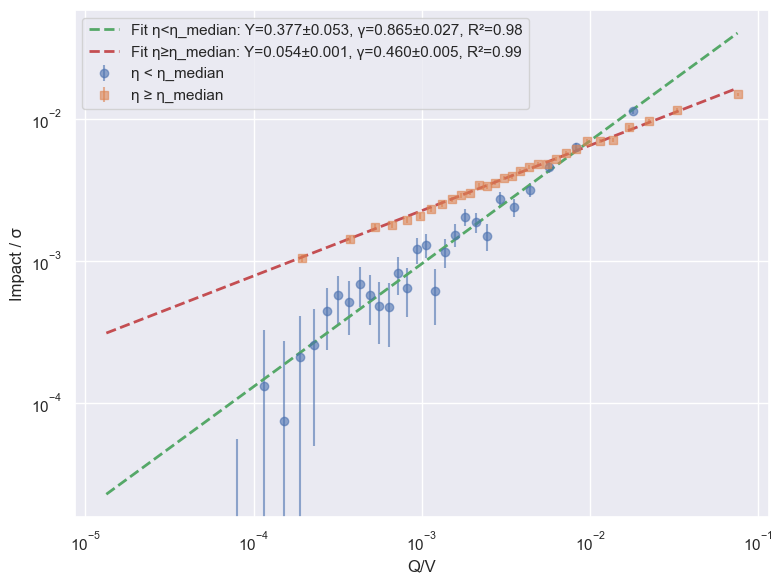

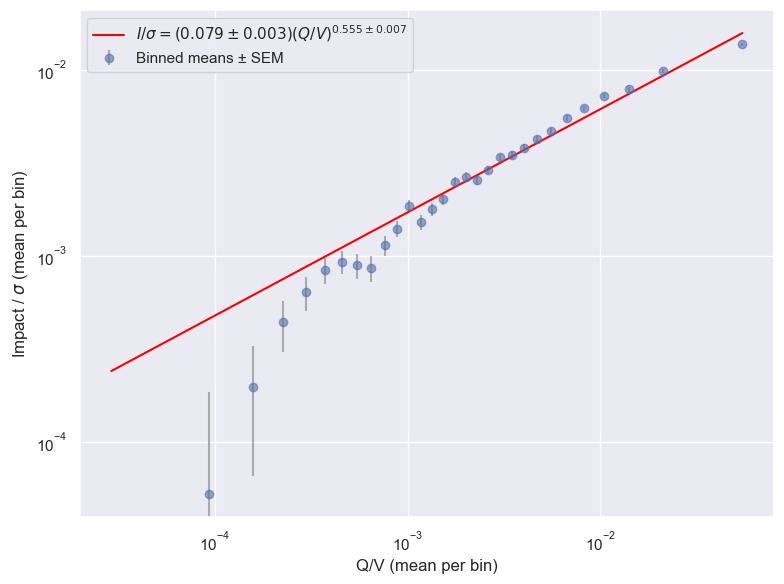

R² of the fitted model: 0.9704


In [23]:
df = metaorders_info_df_sameday.copy()
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Q/V', 'Impact'])

prt_med = df['Participation Rate'].median()
df_low  = df[df['Participation Rate'] <  prt_med].copy()
df_high = df[df['Participation Rate'] >= prt_med].copy()

def power_law(qv, Y, gamma):
    return Y * np.power(qv, gamma)

def fit_power_law_quantile(subdf, n_qbins=8, p0=(1.0, 0.5)):
    subdf = subdf[subdf['Q/V'] > 0].copy()
    subdf['bin'], bins = pd.qcut(subdf['Q/V'], q=n_qbins, labels=False,
                                 retbins=True, duplicates='drop')
    binned = (
        subdf.groupby('bin')
             .agg(mean_QV=('Q/V', 'mean'),
                  mean_imp=('Impact', 'mean'),
                  std_imp=('Impact', 'std'),
                  count=('Impact', 'size'))
             .query('count > 1')
    )
    binned['sem_imp'] = binned['std_imp'] / np.sqrt(binned['count'])
    binned = binned.replace([np.inf, -np.inf], np.nan).dropna(subset=['sem_imp'])

    popt, pcov = curve_fit(
        power_law,
        binned['mean_QV'].values,
        binned['mean_imp'].values,
        sigma=binned['sem_imp'].values,
        absolute_sigma=True,
        p0=p0
    )
    Y, gamma = popt
    Y_err, gamma_err = np.sqrt(np.diag(pcov))

    y_true = binned['mean_imp'].values
    y_pred = power_law(binned['mean_QV'].values, Y, gamma)
    R2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

    return binned, (Y, Y_err, gamma, gamma_err, R2)

n_qbins = 30  # choose the number of quantile bins

stats_low,  params_low  = fit_power_law_quantile(df_low,  n_qbins=n_qbins)
stats_high, params_high = fit_power_law_quantile(df_high, n_qbins=n_qbins, p0=params_low[:2])

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(stats_low['mean_QV'],  stats_low['mean_imp'],  yerr=stats_low['sem_imp'],
            fmt='o', alpha=0.6, label='η < η_median')
ax.errorbar(stats_high['mean_QV'], stats_high['mean_imp'], yerr=stats_high['sem_imp'],
            fmt='s', alpha=0.6, label='η ≥ η_median')

qv_range = np.logspace(
    np.log10(min(stats_low['mean_QV'].min(),  stats_high['mean_QV'].min())),
    np.log10(max(stats_low['mean_QV'].max(), stats_high['mean_QV'].max())),
    200
)

Yl, Yl_err, γl, γl_err, R2l = params_low
Yh, Yh_err, γh, γh_err, R2h = params_high

ax.plot(qv_range, power_law(qv_range, Yl, γl), '--',  lw=2,
        label=rf'Fit η<η_median: Y={Yl:.3f}±{Yl_err:.3f}, γ={γl:.3f}±{γl_err:.3f}, R²={R2l:.2f}')
ax.plot(qv_range, power_law(qv_range, Yh, γh), '--', lw=2,
        label=rf'Fit η≥η_median: Y={Yh:.3f}±{Yh_err:.3f}, γ={γh:.3f}±{γh_err:.3f}, R²={R2h:.2f}')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Q/V'); ax.set_ylabel('Impact / σ'); ax.legend()
plt.tight_layout(); plt.show()


df = metaorders_info_df_sameday.copy()
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Q/V', 'Impact'])

def power_law(qv, Y, gamma):
    return Y * np.power(qv, gamma)

def fit_power_law_quantile(subdf, n_qbins=12, p0=(1.0, 0.5)):
    subdf = subdf[subdf['Q/V'] > 0].copy()
    subdf['bin'], bins = pd.qcut(
        subdf['Q/V'],
        q=n_qbins,
        labels=False,
        retbins=True,
        duplicates='drop'
    )
    binned = (
        subdf.groupby('bin')
             .agg(
                 mean_QV=('Q/V', 'mean'),
                 mean_imp=('Impact', 'mean'),
                 std_imp=('Impact', 'std'),
                 count=('Impact', 'size')
             )
             .query('count > 1')
    )
    binned['sem_imp'] = binned['std_imp'] / np.sqrt(binned['count'])
    binned = binned.replace([np.inf, -np.inf], np.nan).dropna(subset=['sem_imp'])

    popt, pcov = curve_fit(
        power_law,
        binned['mean_QV'].values,
        binned['mean_imp'].values,
        sigma=binned['sem_imp'].values,
        absolute_sigma=True,
        p0=p0
    )
    Y, gamma = popt
    Y_err, gamma_err = np.sqrt(np.diag(pcov))

    y_true = binned['mean_imp'].values
    y_pred = power_law(binned['mean_QV'].values, Y, gamma)
    r_squared = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

    return binned, (Y, Y_err, gamma, gamma_err, r_squared)

n_qbins = 30  # set your preferred number of quantile bins

binned, (Y, Y_err, gamma, gamma_err, r_squared) = fit_power_law_quantile(df, n_qbins=n_qbins)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    binned['mean_QV'],
    binned['mean_imp'],
    yerr=binned['sem_imp'],
    fmt='o',
    ecolor='gray',
    alpha=0.6,
    label='Binned means ± SEM'
)

qv_range = np.logspace(
    np.log10(binned['mean_QV'].min()),
    np.log10(binned['mean_QV'].max()),
    200
)
ax.plot(
    qv_range,
    power_law(qv_range, Y, gamma),
    color='red',
    label=rf'$I/\sigma = ({Y:.3f}\pm{Y_err:.3f})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$'
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q/V (mean per bin)')
ax.set_ylabel(r'Impact / $\sigma$ (mean per bin)')
ax.legend()
plt.tight_layout()
plt.show()

print(f'R² of the fitted model: {r_squared:.4f}')

"""
Square-root / power-law impact fit with log–log WLS on binned means
-------------------------------------------------------------------

Procedure (consistent with the uploaded papers on price formation and impact):

1) Preprocess:
   - Compute Impact = (Price Change * Direction) / Daily Vol.
   - Drop non-finite values and require Q/V > 0 (log-space requirement).

2) Log binning in Q/V:
   - Build a fixed grid of `n_logbins` edges between min(Q/V) and max(Q/V).
   - Assign each trade/metaorder to a bin.
   - For each bin, compute the conditional *mean* Impact (or median if `use_median=True`),
     its sample standard deviation, and SEM = std / sqrt(n).
   - Use the *geometric* center of each bin: sqrt(left_edge * right_edge).

3) Weighted least squares in log–log space:
   - Model on binned points:  log(mean_imp) = log(Y) + γ * log(center_QV).
   - Use delta-method weights for log(means):
       Var[log(mean_imp)] ≈ (SEM / mean_imp)^2  ⇒  w = 1 / Var.
     (Only bins with mean_imp > 0 and SEM > 0 are kept.)
   - Solve WLS to estimate (log Y, γ). Convert to Y = exp(log Y).
   - Standard errors:
       cov(β) ≈ σ² * (X' W X)^{-1}, with σ² from weighted residuals;
       se(Y) via delta method: se(Y) = Y * se(log Y).

4) Goodness of fit:
   - Report weighted R² on the log scale and an intuitive (unweighted) R² on the original scale
     using the binned mean_imp values.

5) Outputs:
   - Overall fit (all metaorders).
   - PR-conditioned fits: split Participation Rate into quantile groups and repeat the same
     binning + WLS procedure per group, plotted on a single figure.

Notes:
- Deviations at the smallest and largest Q/V are expected (microstructure/linear regime at very low sizes; 
  saturation/shallower scaling at very high participation or aggressiveness).
- Choose `min_count` to ensure reliable bin statistics (avoid SEM=0 and unstable bins).
"""

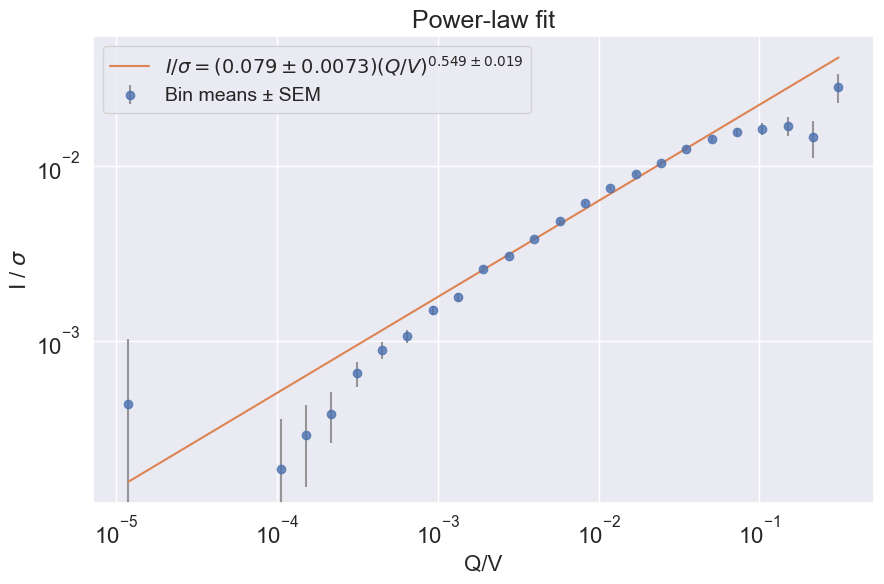

--- Overall (All) ---
Y = 0.0790062 ± 0.00725
γ = 0.548706 ± 0.0188
R²_log = 0.9748 | R²_lin = 0.4197
Bins used: 24 (min_count ≥ 20)


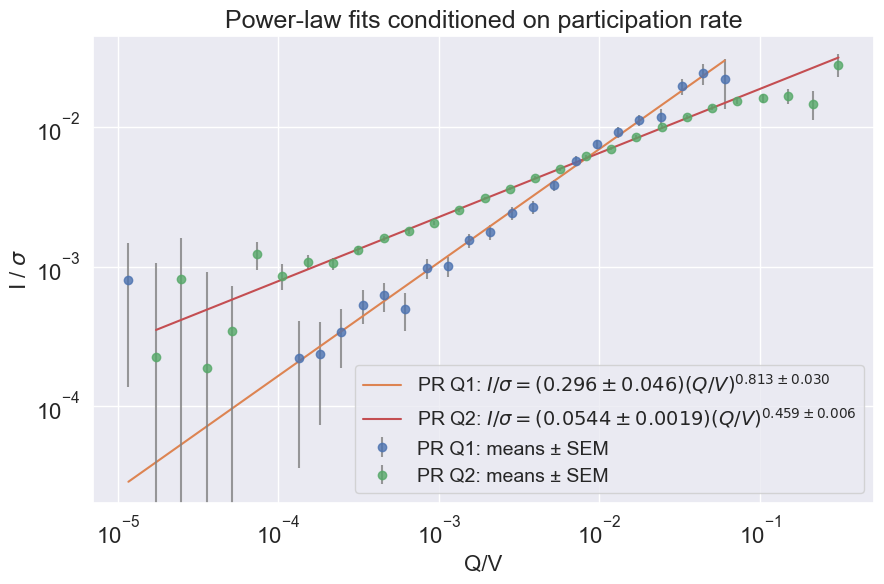

--- Conditioned on Participation Rate ---
[PR Q1]  Y = 0.295667 ± 0.0461 | γ = 0.813176 ± 0.0298 |
[PR Q2]  Y = 0.0543632 ± 0.0019 | γ = 0.459428 ± 0.00641 |


In [24]:
# Prepare data
df = metaorders_info_df_sameday.copy()
df = df[df['Q/V'] > 1e-5]
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Q/V', 'Impact'])
df = df[df['Q/V'] > 0]  # strictly positive for log space

# Font sizes
LABEL_SIZE = 16
LEGEND_SIZE = 14
TITLE_SIZE = 18

# (optional) set some global defaults to align with the parameters
plt.rcParams.update({
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": LEGEND_SIZE,
})

# ----------------------------
# Utilities
# ----------------------------
def power_law(qv, Y, gamma):
    """I/sigma = Y * (Q/V)^gamma"""
    return Y * np.power(qv, gamma)

def fit_power_law_logbins_wls(
    subdf: pd.DataFrame,
    n_logbins: int = 30,
    min_count: int = 100,        # reliability filter: keep only bins with enough obs
    use_median: bool = False     # set True for robustness; paper uses conditional averages (means)
):
    """
    Bin on a fixed log grid in Q/V, compute conditional mean Impact per bin,
    estimate Y, gamma in log–log space via weighted least squares:
        log(I) = log(Y) + gamma * log(Q/V)
    with weights w = 1 / Var[log(mean_imp)] ≈ (mean_imp / SEM)^2.

    Returns:
        binned_df: DataFrame with center_QV, mean_imp, sem_imp, count
        params   : (Y, Y_se, gamma, gamma_se, R2_log, R2_lin)
    """
    sub = subdf[(subdf['Q/V'] > 0) & np.isfinite(subdf['Impact'])].copy()
    if sub.empty:
        raise ValueError("No valid rows (Q/V>0 and finite Impact).")

    x = sub['Q/V'].to_numpy()
    y = sub['Impact'].to_numpy()

    # Fixed log grid on observed support
    x_min = x.min()
    x_max = x.max()
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        raise ValueError("Invalid Q/V range for log binning.")
    edges = np.logspace(np.log10(x_min), np.log10(x_max), n_logbins + 1)

    # Assign bins
    bin_idx = np.digitize(x, edges) - 1
    mask = (bin_idx >= 0) & (bin_idx < n_logbins)
    x, y, bin_idx = x[mask], y[mask], bin_idx[mask]

    # --- Aggregate in each bin (robust to empty bins) ---
    dfb = pd.DataFrame({'x': x, 'y': y, 'bin': bin_idx})

    agg = (
        dfb.groupby('bin')['y']
           .agg(mean_imp='mean',
                median_imp='median',
                std_imp=lambda s: s.std(ddof=1),
                count='size')
           .sort_index()
    )

    # choose mean/median for the fit
    y_stat = agg['median_imp'] if use_median else agg['mean_imp']
    y_std  = agg['std_imp'].to_numpy()
    n      = agg['count'].to_numpy()
    sem    = y_std / np.sqrt(np.maximum(n, 1))

    # geometric centers for the *present* bins only
    bins_present = agg.index.to_numpy()
    left_edges   = edges[bins_present]
    right_edges  = edges[bins_present + 1]
    x_center     = np.sqrt(left_edges * right_edges)

    binned = pd.DataFrame({
        'center_QV': x_center,
        'mean_imp':  y_stat.to_numpy(),
        'std_imp':   y_std,
        'sem_imp':   sem,
        'count':     n
    }).sort_values('center_QV').reset_index(drop=True)

    # Reliability & positivity filters for log fit
    binned = binned[
        (binned['count'] >= min_count) &
        np.isfinite(binned['mean_imp']) &
        np.isfinite(binned['sem_imp']) &
        (binned['sem_imp'] > 0) &
        (binned['mean_imp'] > 0)
    ]
    if len(binned) < 3:
        raise ValueError(f"Not enough valid bins after filtering (got {len(binned)}). "
                         f"Try lowering min_count or n_logbins.")

    X = np.log(binned['center_QV'].to_numpy())
    Z = np.log(binned['mean_imp'].to_numpy())

    # Delta-method weights: Var[log(mean_imp)] ≈ (SEM/mean)^2  => w = 1/Var
    var_logy = (binned['sem_imp'].to_numpy() / binned['mean_imp'].to_numpy())**2
    w = 1.0 / var_logy
    w = np.where(np.isfinite(w) & (w > 0), w, 0)

    # Weighted least squares for Z = a + gamma * X  (Y = exp(a))
    A = np.vstack([np.ones_like(X), X]).T
    Aw = A * np.sqrt(w)[:, None]
    Zw = Z * np.sqrt(w)
    coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
    a_hat, gamma_hat = coef
    Y_hat = np.exp(a_hat)

    # Covariance of coefficients: cov ≈ sigma^2 * (X' W X)^(-1), sigma^2 from weighted residuals
    res  = Z - (a_hat + gamma_hat * X)
    RSS  = np.sum(w * res**2)
    dof  = max(len(Z) - 2, 1)
    s2   = RSS / dof
    XtWX = A.T @ (w[:, None] * A)
    cov  = s2 * np.linalg.inv(XtWX)
    a_se, gamma_se = np.sqrt(np.diag(cov))
    Y_se = Y_hat * a_se  # delta-method

    # R^2 on log scale (weighted) and on original scale (unweighted, for intuition)
    Zhat = a_hat + gamma_hat * X
    Zbar = np.average(Z, weights=w)
    R2_log = 1.0 - np.sum(w * (Z - Zhat)**2) / np.sum(w * (Z - Zbar)**2)

    yhat   = power_law(binned['center_QV'].to_numpy(), Y_hat, gamma_hat)
    ybar   = np.mean(binned['mean_imp'].to_numpy())
    R2_lin = 1.0 - np.sum((binned['mean_imp'].to_numpy() - yhat)**2) / np.sum((binned['mean_imp'].to_numpy() - ybar)**2)

    return binned, (Y_hat, Y_se, gamma_hat, gamma_se, R2_log, R2_lin)

def plot_fit(ax, binned: pd.DataFrame, params, label_prefix=None,
             label_size: int = LABEL_SIZE, legend_size: int = LEGEND_SIZE):
    """Scatter with SEM bars and fitted curve on log–log axes."""
    Y, Y_err, gamma, gamma_err, R2_log, R2_lin = params

    ax.errorbar(
        binned['center_QV'],
        binned['mean_imp'],
        yerr=binned['sem_imp'],
        fmt='o', alpha=0.8, ecolor='gray',
        label='Bin means ± SEM' if label_prefix is None else f'{label_prefix}: means ± SEM'
    )

    x_min, x_max = binned['center_QV'].min(), binned['center_QV'].max()
    x_grid = np.logspace(np.log10(x_min), np.log10(x_max), 300)
    ax.plot(
        x_grid, power_law(x_grid, Y, gamma),
        label=(rf'{"" if label_prefix is None else label_prefix + ": "}'
               rf'$I/\sigma = ({Y:.3g}\pm{Y_err:.2g})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$')
    )

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Q/V', fontsize=label_size)
    ax.set_ylabel(r'I / $\sigma$', fontsize=label_size)
    ax.tick_params(axis='both', which='both', labelsize=label_size)
    ax.legend(loc='best', fontsize=legend_size)

# ----------------------------
# 1) Overall fit (all metaorders)
# ----------------------------
n_logbins = 30
min_count = 20  # raise for larger datasets; lower if data is sparse

binned_all, params_all = fit_power_law_logbins_wls(
    df, n_logbins=n_logbins, min_count=min_count, use_median=False
)

fig, ax = plt.subplots(figsize=(9, 6))
plot_fit(ax, binned_all, params_all)  # sizes are controlled by LABEL_SIZE/LEGEND_SIZE
ax.set_title('Power-law fit', fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f'images/power_law_fit_overall_{LEVEL}.png', dpi=300)
plt.show()

print('--- Overall (All) ---')
print(f'Y = {params_all[0]:.6g} ± {params_all[1]:.3g}')
print(f'γ = {params_all[2]:.6f} ± {params_all[3]:.3g}')
print(f'R²_log = {params_all[4]:.4f} | R²_lin = {params_all[5]:.4f}')
print(f'Bins used: {len(binned_all)} (min_count ≥ {min_count})')

# ----------------------------
# 2) Conditioning on Participation Rate
# ----------------------------
PR_CANDIDATES = 'Participation Rate'

# Define participation-rate groups via quantiles (change nbins if needed)
pr_nbins = 2
labels = [f'Q{j+1}' for j in range(pr_nbins)]
df = df.copy()
df['PR_bin'] = pd.qcut(df[PR_CANDIDATES], q=pr_nbins, labels=labels, duplicates='drop')

# Fit and plot one curve per PR bin using the *same* WLS procedure
fig, ax = plt.subplots(figsize=(9, 6))
legend_entries = []
fits_by_pr = {}

for label in df['PR_bin'].dropna().unique():
    sub = df[df['PR_bin'] == label]
    try:
        binned_sub, params_sub = fit_power_law_logbins_wls(
            sub, n_logbins=n_logbins, min_count=min_count, use_median=False
        )
    except Exception as e:
        print(f"[{label}] skipped: {e}")
        continue

    plot_fit(ax, binned_sub, params_sub, label_prefix=f'PR {label}')
    fits_by_pr[str(label)] = params_sub

ax.set_title('Power-law fits conditioned on participation rate', fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f'images/power_law_fits_by_participation_rate_{LEVEL}.png', dpi=300)
plt.show()

print('--- Conditioned on Participation Rate ---')
for k, (Y, Y_se, gamma, gamma_se, R2_log, R2_lin) in fits_by_pr.items():
    print(f"[PR {k}]  Y = {Y:.6g} ± {Y_se:.3g} | γ = {gamma:.6f} ± {gamma_se:.3g} |")


### Clusterization


In [2]:
metaorders_info_df_sameday = pd.read_parquet(f'out_files/metaorders_info_sameday_filtered_{LEVEL}.parquet')
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,91096,1126,-1,0.000844,0.070867,709.0,0.001766,0.025336,2,"[2024-06-03T15:08:46.533298, 2024-06-03T15:41:..."
1,IT0000062072,91096,1126,1,0.005466,0.085787,520.0,0.000991,0.004665,3,"[2024-06-06T14:38:51.747916, 2024-06-06T16:07:..."
2,IT0000062072,91096,1126,-1,0.000839,0.085787,450.0,0.000858,0.014089,2,"[2024-06-06T16:13:43.120247, 2024-06-06T16:51:..."
3,IT0000062072,91096,1092,-1,0.001270,0.087037,600.0,0.001196,0.039355,2,"[2024-06-10T11:25:15.905795, 2024-06-10T11:35:..."
4,IT0000062072,91096,1126,1,-0.002550,0.098976,250.0,0.000320,0.004919,2,"[2024-06-11T11:46:51.127009, 2024-06-11T12:12:..."
...,...,...,...,...,...,...,...,...,...,...,...
682881,NL0015435975,96828,5493,1,0.000000,0.097384,43420.0,0.021485,0.147121,16,"[2025-05-30T14:09:33.993048, 2025-05-30T15:32:..."
682882,NL0015435975,96828,5493,1,-0.000694,0.097384,5301.0,0.002623,0.901684,3,"[2025-05-30T15:34:55.319651, 2025-05-30T15:37:..."
682883,NL0015435975,96828,5493,1,-0.001731,0.097384,17861.0,0.008838,0.186009,6,"[2025-05-30T15:46:18.640139, 2025-05-30T16:15:..."
682884,NL0015435975,96828,5493,-1,-0.003131,0.097384,12782.0,0.006325,0.085883,2,"[2025-05-30T16:21:02.828230, 2025-05-30T16:57:..."


In [5]:
metaorders_info_df_sameday.groupby('Member').agg({'Price Change': lambda x: x.abs().mean()})

,Price Change
Member,
5032,0.000694
5046,0.000574
5104,0.002044
5134,0.000936
5264,0.001828
...,...
624871,0.001441
628759,0.001058
628760,0.001603


K=2: silhouette score = 0.4971
K=3: silhouette score = 0.3000
K=4: silhouette score = 0.2136
K=5: silhouette score = 0.1346
K=6: silhouette score = 0.1622
Selected K = 2 (silhouette = 0.497 if finite)


,logY_dev,gamma_dev,resid_log_med,resid_log_iqr,eta_med
cluster,,,,,
0,0.403237,0.135496,-0.195514,1.591657,0.296808
1,0.176539,0.018888,-0.019632,1.391994,0.071775


,n_brokers,total_metaorders,median_logY_dev,median_gamma_dev,median_resid_log,median_eta
cluster,,,,,,
0,4,87857,-0.429183,0.014596,-0.310560,0.309846
1,46,275760,-0.175985,-0.048868,-0.019753,0.053535


,Member,n_metaorders,logY_dev,gamma_dev,resid_log_med,resid_log_iqr,eta_med,qv_log_span,cluster
0,5032,160,-1.835991,-0.192067,-0.343344,1.618193,0.194805,1.708123,1
30,96894,379,-1.326939,-0.139306,-0.386324,1.730391,0.313078,1.883107,0
4,47315,247,-1.137265,-0.123152,-0.011765,1.316324,0.054450,1.433235,1
1,5264,242,-1.055981,-0.175720,-0.018763,1.394244,0.022256,1.568801,1
28,96889,397,-1.002844,-0.137578,-0.006717,1.414749,0.034777,1.893800,1
25,96874,438,-0.964738,-0.111537,-0.041395,1.569511,0.069338,1.778248,1
7,91096,220,-0.848000,-0.080308,0.012491,1.209588,0.163587,2.000717,1
11,91147,659,-0.826775,-0.150933,-0.140548,1.528614,0.004957,2.482403,1
2,38565,176,-0.799749,-0.134999,-0.003391,1.254182,0.024231,1.460053,1
41,117416,540,-0.781298,-0.045683,-0.385510,1.700044,0.306615,1.906045,0


,Member,n_metaorders,logY_dev,gamma_dev,resid_log_med,resid_log_iqr,eta_med,qv_log_span,cluster
37,116286,551,1.146834,0.070818,0.091707,1.617627,0.015261,1.574561,1
43,590698,176,1.036795,0.164771,0.086133,1.232020,0.121856,1.482172,1
18,96828,17660,0.705084,0.107707,0.001446,1.292634,0.131986,1.699522,1
14,91166,13542,0.597299,0.054024,0.027884,1.467237,0.048500,1.826562,1
10,91146,21427,0.574018,0.081578,0.003993,1.377435,0.087480,1.564682,1
44,622652,814,0.569803,0.092326,0.048547,1.269183,0.048195,1.436115,1
40,117379,940,0.445810,0.040526,0.013321,1.434349,0.064626,1.940691,1
13,91157,85442,0.426807,0.138922,-0.192765,1.590559,0.296344,1.576117,0
9,91139,52404,0.380620,0.054959,-0.007919,1.354187,0.064263,1.588086,1
31,96909,6908,0.273272,0.014231,-0.098492,1.412821,0.054087,2.020400,1


C:\Users\dinosse\AppData\Local\Temp\ipykernel_23908\2962526643.py:244: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_palette = plt.cm.get_cmap('tab10', best_model.n_clusters)


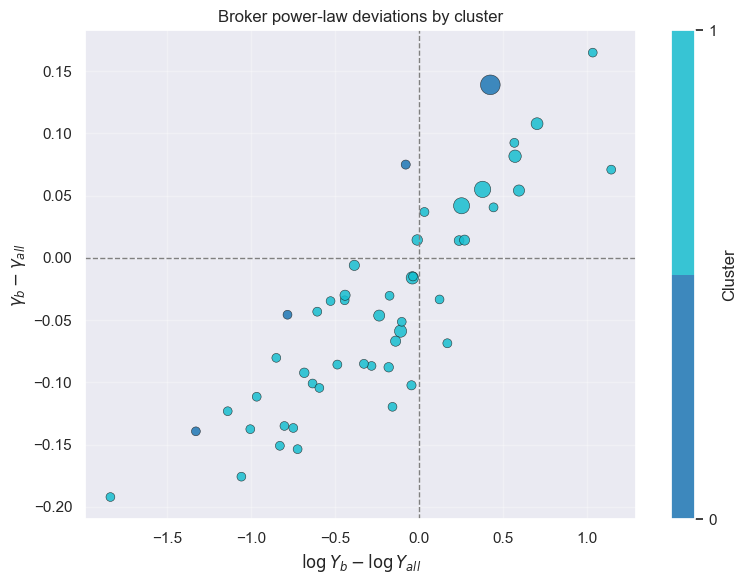

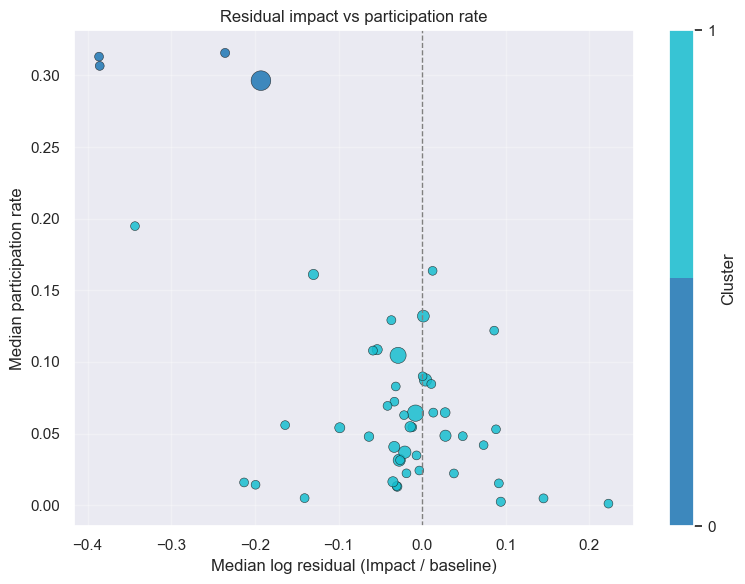

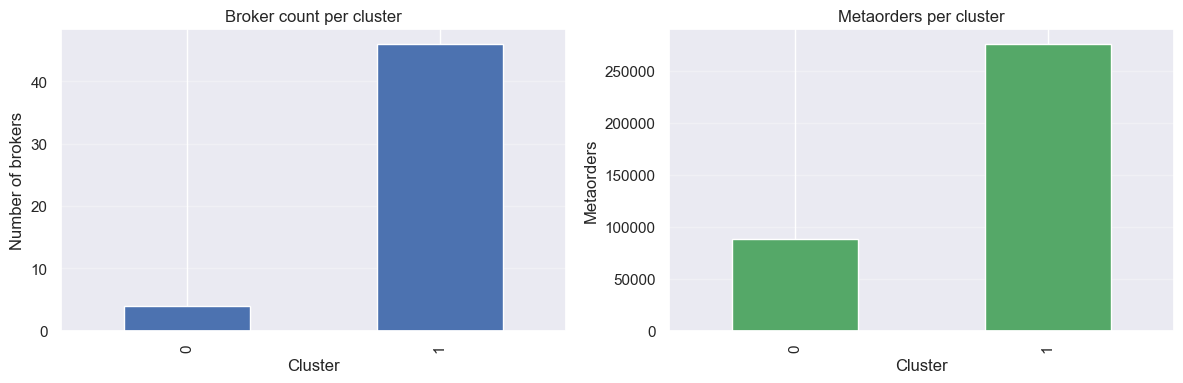

In [4]:
# Broker-level impact clustering via k-means
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


try:
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler
except ImportError as exc:
    raise ImportError("scikit-learn is required for the broker clustering analysis cell.") from exc

def _replace_inf_with_nan(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        df.loc[:, numeric_cols] = df.loc[:, numeric_cols].replace([np.inf, -np.inf], np.nan)
    return df

level='member'
metaorders_info_df_sameday = pd.read_parquet(f'out_files/metaorders_info_sameday_filtered_{LEVEL}.parquet')
cluster_df = metaorders_info_df_sameday.copy()
cluster_df = cluster_df[cluster_df['Price Change'] != 0]
if "Impact" not in cluster_df.columns and {"Price Change", "Direction", "Daily Vol"}.issubset(cluster_df.columns):
    cluster_df["Impact"] = cluster_df["Price Change"] * cluster_df["Direction"] / cluster_df["Daily Vol"]

cluster_df = _replace_inf_with_nan(cluster_df)
cluster_df = cluster_df.dropna(subset=["Q/V", "Impact"])
cluster_df = cluster_df[cluster_df["Q/V"] > 0].copy()

if cluster_df.empty:
    raise RuntimeError("Metaorder info dataframe is empty after filtering; cannot run clustering.")


def power_law(qv, Y, gamma):
    return Y * np.power(qv, gamma)


def fit_power_law_binned(subdf, n_logbins=30, min_count=20):
    """Fit impact = Y * (Q/V)^gamma using fixed log-spaced bins and WLS (see cell 47)."""
    tmp = subdf[(subdf["Q/V"] > 0) & np.isfinite(subdf["Impact"])].copy()
    if tmp.empty:
        return None, (np.nan, np.nan)
    tmp = _replace_inf_with_nan(tmp)

    qv = tmp["Q/V"].to_numpy(dtype=float)
    impact = tmp["Impact"].to_numpy(dtype=float)
    x_min = np.nanmin(qv)
    x_max = np.nanmax(qv)
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        return None, (np.nan, np.nan)

    edges = np.logspace(np.log10(x_min), np.log10(x_max), n_logbins + 1)
    bin_idx = np.digitize(qv, edges) - 1
    mask = (bin_idx >= 0) & (bin_idx < n_logbins)
    if mask.sum() < 3:
        return None, (np.nan, np.nan)

    df_bins = pd.DataFrame({
        "bin": bin_idx[mask],
        "Impact": impact[mask],
    })
    agg = (
        df_bins.groupby("bin")["Impact"]
              .agg(mean_imp="mean",
                   std_imp=lambda s: s.std(ddof=1),
                   count="size")
              .sort_index()
    )
    bins_present = agg.index.to_numpy()
    left = edges[bins_present]
    right = edges[bins_present + 1]
    centers = np.sqrt(left * right)

    agg["std_imp"] = agg["std_imp"].fillna(0.0)
    agg["sem_imp"] = agg["std_imp"] / np.sqrt(np.maximum(agg["count"], 1))
    binned = agg.assign(center_QV=centers)[["center_QV", "mean_imp", "std_imp", "sem_imp", "count"]]

    binned = binned[
        (binned["count"] >= min_count) &
        np.isfinite(binned["mean_imp"]) &
        np.isfinite(binned["sem_imp"]) &
        (binned["mean_imp"] > 0) &
        (binned["sem_imp"] > 0)
    ]
    if len(binned) < 3:
        return None, (np.nan, np.nan)

    X = np.log(binned["center_QV"].to_numpy())
    Z = np.log(binned["mean_imp"].to_numpy())
    var_logy = (binned["sem_imp"].to_numpy() / binned["mean_imp"].to_numpy()) ** 2
    w = np.where(np.isfinite(var_logy) & (var_logy > 0), 1.0 / var_logy, 0.0)
    mask = w > 0
    if mask.sum() < 2:
        return None, (np.nan, np.nan)

    A = np.vstack([np.ones_like(X), X]).T
    A = A[mask]
    Z = Z[mask]
    w = w[mask]
    Aw = A * np.sqrt(w)[:, None]
    Zw = Z * np.sqrt(w)
    coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
    a_hat, gamma_hat = coef
    Y_hat = float(np.exp(a_hat))
    gamma_hat = float(gamma_hat)

    return binned.reset_index(drop=True), (Y_hat, gamma_hat)

def log_qv_span(series, lower=0.1, upper=0.9):
    log_vals = np.log10(series.to_numpy(dtype=float))
    log_vals = log_vals[np.isfinite(log_vals)]
    if log_vals.size == 0:
        return np.nan
    q_low, q_high = np.nanpercentile(log_vals, [lower * 100, upper * 100])
    return float(q_high - q_low)


baseline = cluster_df[cluster_df["Impact"] > 0].copy()
if baseline.empty:
    raise RuntimeError("No positive impacts available for baseline fit.")
_, (Y_all, gamma_all) = fit_power_law_binned(baseline, n_logbins=30, min_count=20)
if not (np.isfinite(Y_all) and np.isfinite(gamma_all) and Y_all > 0):
    raise RuntimeError("Global power-law fit failed; cannot run clustering.")

cluster_df["I_hat"] = power_law(cluster_df["Q/V"].to_numpy(), Y_all, gamma_all)
cluster_df = _replace_inf_with_nan(cluster_df)
cluster_df = cluster_df.dropna(subset=["I_hat"])
cluster_df = cluster_df[cluster_df["I_hat"] > 0]
EPS = 1e-9
impact_vals = cluster_df["Impact"].to_numpy()
ihat_vals = cluster_df["I_hat"].to_numpy()
finite_mask = np.isfinite(impact_vals) & np.isfinite(ihat_vals)
# nonzero_mask = ~np.isclose(impact_vals, 0.0)
cluster_df = cluster_df.loc[finite_mask].copy()
cluster_df["resid_log"] = np.sign(cluster_df["Impact"]) * (
    np.log(np.abs(cluster_df["Impact"]) + EPS) - np.log(cluster_df["I_hat"] + EPS)
)

min_metaorders = 100
min_log_span = 0.5
broker_rows = []

for broker_id, broker_df in cluster_df.groupby("Member"):
    broker_positive = broker_df[broker_df["Impact"] > 0]
    n_meta = len(broker_positive)
    if n_meta < min_metaorders:
        continue
    span = log_qv_span(broker_df["Q/V"])
    if not np.isfinite(span) or span < min_log_span:
        continue
    q_bins = min(20, max(4, int(np.sqrt(n_meta))))
    _, (Y_b, gamma_b) = fit_power_law_binned(broker_positive, n_logbins=q_bins, min_count=10)
    if not (np.isfinite(Y_b) and np.isfinite(gamma_b) and Y_b > 0):
        x = np.log(broker_positive["Q/V"].to_numpy())
        y = np.log(np.clip(broker_positive["Impact"].to_numpy(), 1e-12, None))
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 5:
            continue
        gamma_b = gamma_all
        Y_b = float(np.exp(np.nanmean(y[mask] - gamma_b * x[mask])))
    resid_log = broker_df["resid_log"].dropna()
    if resid_log.empty:
        continue
    broker_rows.append({
        "Member": broker_id,
        "n_metaorders": n_meta,
        "logY_dev": float(np.log(Y_b) - np.log(Y_all)),
        "gamma_dev": float(gamma_b - gamma_all),
        "resid_log_med": float(np.nanmedian(resid_log)),
        "resid_log_iqr": float(np.nanpercentile(resid_log, 75) - np.nanpercentile(resid_log, 25)),
        "eta_med": float(np.nanmedian(broker_df["Participation Rate"])),
        "qv_log_span": span,
    })

broker_metrics = pd.DataFrame(broker_rows)
if broker_metrics.empty:
    raise RuntimeError("No brokers passed the coverage filters. Lower the thresholds and rerun.")

feature_cols = ["logY_dev", "gamma_dev", "resid_log_med", "resid_log_iqr", "eta_med"]
features = broker_metrics[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
scaler = StandardScaler()
X = scaler.fit_transform(features)

weights = broker_metrics["n_metaorders"].to_numpy(dtype=float)
weights = np.where(np.isfinite(weights), weights, 0.0)
median_w = np.median(weights[weights > 0]) if np.any(weights > 0) else 1.0
weights = weights / median_w
weights = np.where(weights > 0, weights, 1.0)

max_clusters = min(6, len(broker_metrics))
if max_clusters < 2:
    raise RuntimeError("Not enough brokers for clustering.")

best_model = None
best_labels = None
best_score = -np.inf

for k in range(2, max_clusters + 1):
    km = KMeans(n_clusters=k, random_state=0, n_init="auto")
    labels = km.fit_predict(X, sample_weight=weights)
    if len(np.unique(labels)) < 2:
        continue
    try:
        score = silhouette_score(X, labels, sample_weight=weights)
    except TypeError:
        score = silhouette_score(X, labels)
    print(f"K={k}: silhouette score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_model = km
        best_labels = labels

if best_model is None:
    best_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
    best_labels = best_model.fit_predict(X, sample_weight=weights)
    best_score = np.nan

broker_metrics["cluster"] = best_labels
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(best_model.cluster_centers_),
    columns=feature_cols,
)
cluster_centers["cluster"] = np.arange(len(cluster_centers))
cluster_centers = cluster_centers.set_index("cluster")

cluster_summary = broker_metrics.groupby("cluster").agg(
    n_brokers=("Member", "count"),
    total_metaorders=("n_metaorders", "sum"),
    median_logY_dev=("logY_dev", "median"),
    median_gamma_dev=("gamma_dev", "median"),
    median_resid_log=("resid_log_med", "median"),
    median_eta=("eta_med", "median"),
).sort_values("median_logY_dev")

print(f"Selected K = {best_model.n_clusters} (silhouette = {best_score:.3f} if finite)")
display(cluster_centers)
display(cluster_summary)
display(broker_metrics.sort_values(["logY_dev", "resid_log_med"]).head(10))
display(broker_metrics.sort_values(["logY_dev", "resid_log_med"], ascending=[False, False]).head(10))

# --- Visualizations to inspect cluster structure ---
cluster_palette = plt.cm.get_cmap('tab10', best_model.n_clusters)
size_scale = broker_metrics['n_metaorders'] / broker_metrics['n_metaorders'].max()
size_scale = size_scale.fillna(0)
marker_sizes = 40 + 160 * size_scale

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    broker_metrics['logY_dev'],
    broker_metrics['gamma_dev'],
    c=broker_metrics['cluster'],
    cmap=cluster_palette,
    s=marker_sizes,
    alpha=0.85,
    edgecolors='k',
    linewidths=0.4,
)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel(r'$\log Y_b - \log Y_{all}$')
ax.set_ylabel(r'$\gamma_b - \gamma_{all}$')
ax.set_title('Broker power-law deviations by cluster')
cbar = fig.colorbar(scatter, ax=ax, ticks=range(best_model.n_clusters))
cbar.set_label('Cluster')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
scatter2 = ax.scatter(
    broker_metrics['resid_log_med'],
    broker_metrics['eta_med'],
    c=broker_metrics['cluster'],
    cmap=cluster_palette,
    s=marker_sizes,
    alpha=0.85,
    edgecolors='k',
    linewidths=0.4,
)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Median log residual (Impact / baseline)')
ax.set_ylabel('Median participation rate')
ax.set_title('Residual impact vs participation rate')
cbar2 = fig.colorbar(scatter2, ax=ax, ticks=range(best_model.n_clusters))
cbar2.set_label('Cluster')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
cluster_summary['n_brokers'].plot(kind='bar', ax=axes[0], color='#4C72B0')
axes[0].set_title('Broker count per cluster')
axes[0].set_ylabel('Number of brokers')
axes[0].set_xlabel('Cluster')
cluster_summary['total_metaorders'].plot(kind='bar', ax=axes[1], color='#55A868')
axes[1].set_title('Metaorders per cluster')
axes[1].set_ylabel('Metaorders')
axes[1].set_xlabel('Cluster')
for axis in axes:
    axis.grid(alpha=0.3, axis='y')
fig.tight_layout()
plt.show()


In [20]:
# PCA on broker feature space used for K-means
from sklearn.decomposition import PCA

required_vars = ['broker_metrics', 'feature_cols']
missing = [var for var in required_vars if var not in globals()]
if missing:
    raise RuntimeError(f"Missing variables for PCA: {missing}. Run the clustering cell first.")

features_for_pca = broker_metrics[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
scaler_pca = StandardScaler()
X_pca = scaler_pca.fit_transform(features_for_pca)

pca = PCA()
pca.fit(X_pca)

explained_variance = pd.DataFrame({
    'Component': np.arange(1, len(feature_cols) + 1),
    'Explained Variance': pca.explained_variance_,
    'Explained Variance Ratio': pca.explained_variance_ratio_,
}).set_index('Component')

loadings = pd.DataFrame(
    pca.components_,
    columns=feature_cols,
    index=[f'PC{i}' for i in range(1, len(feature_cols) + 1)]
)

print('Explained variance by component:')
display(explained_variance)

print('Feature contributions (loadings) per principal component:')
display(loadings)


Explained variance by component:


,Explained Variance,Explained Variance Ratio
Component,,
1,2.301178,0.451031
2,1.668728,0.327071
3,0.834144,0.163492
4,0.266675,0.052268
5,0.031316,0.006138


Feature contributions (loadings) per principal component:


,logY_dev,gamma_dev,resid_log_med,resid_log_iqr,eta_med
PC1,0.576832,0.457430,0.492951,-0.357062,-0.295851
PC2,0.307890,0.560173,-0.396870,0.132482,0.645253
PC3,0.270987,-0.007031,0.261505,0.914122,-0.150045
PC4,-0.288964,-0.035170,0.727922,-0.021007,0.620445
PC5,-0.644619,0.689694,0.035183,0.137462,-0.297750


Number of feature triplets (combinations of 3 over 5): 10


C:\Users\dinosse\AppData\Local\Temp\ipykernel_932\2777168731.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_palette = plt.cm.get_cmap('tab10', len(np.unique(clusters)))


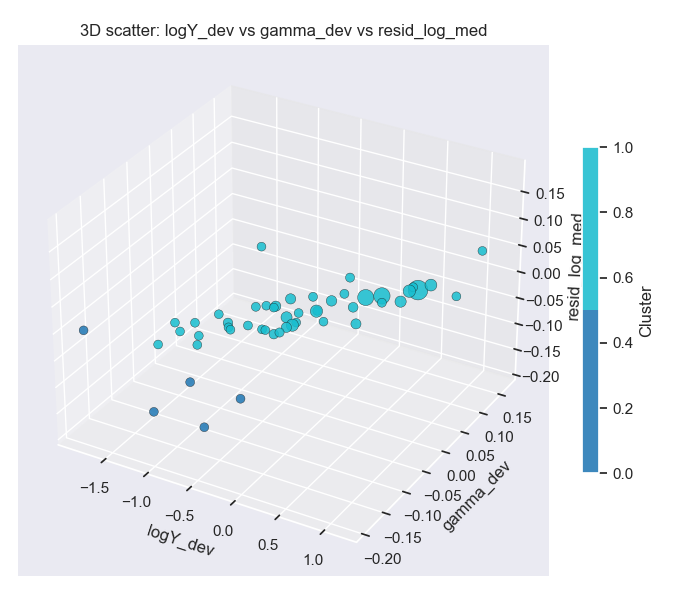

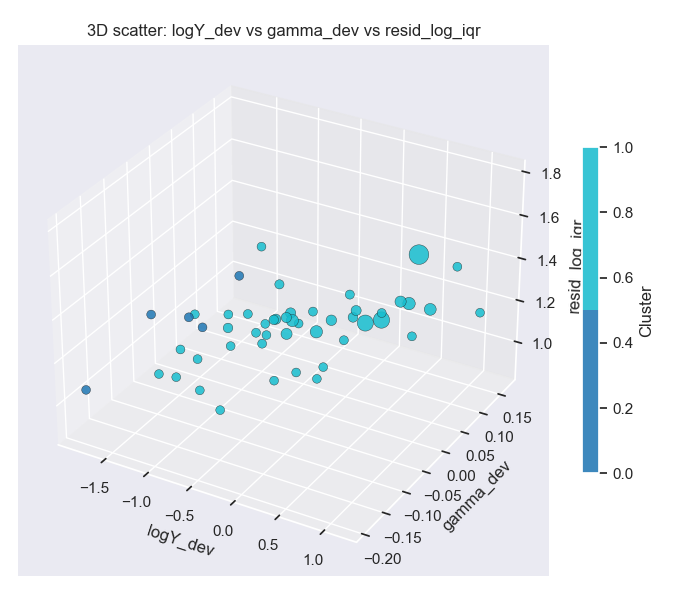

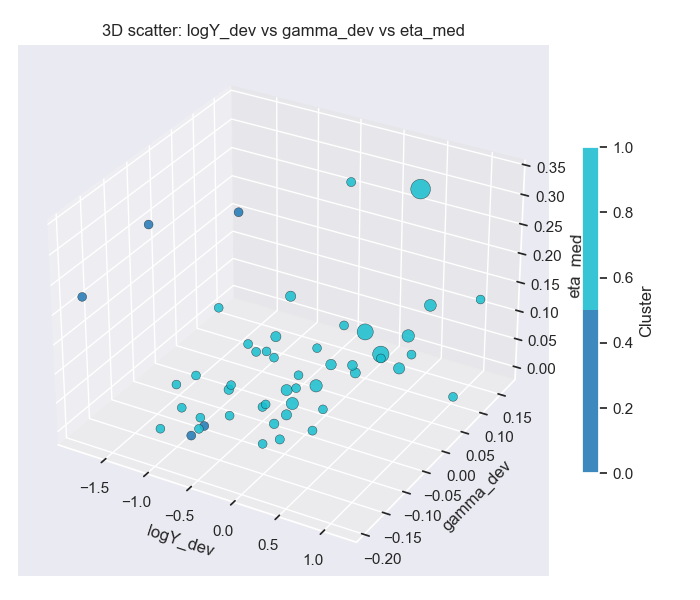

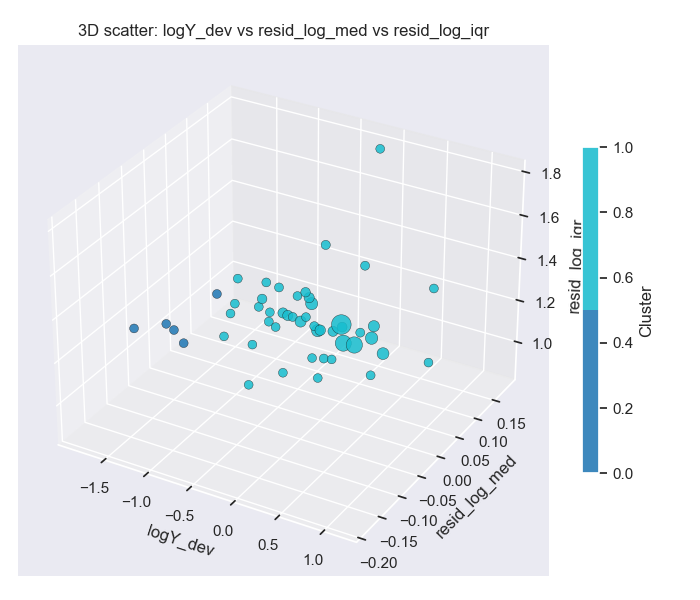

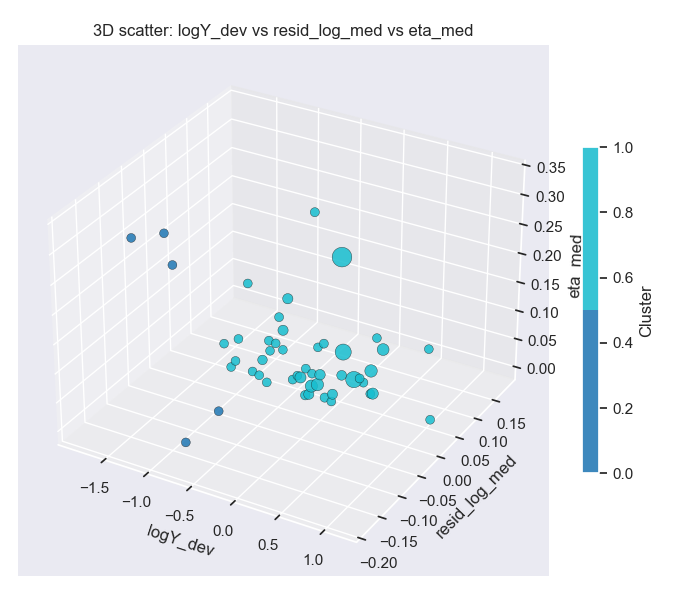

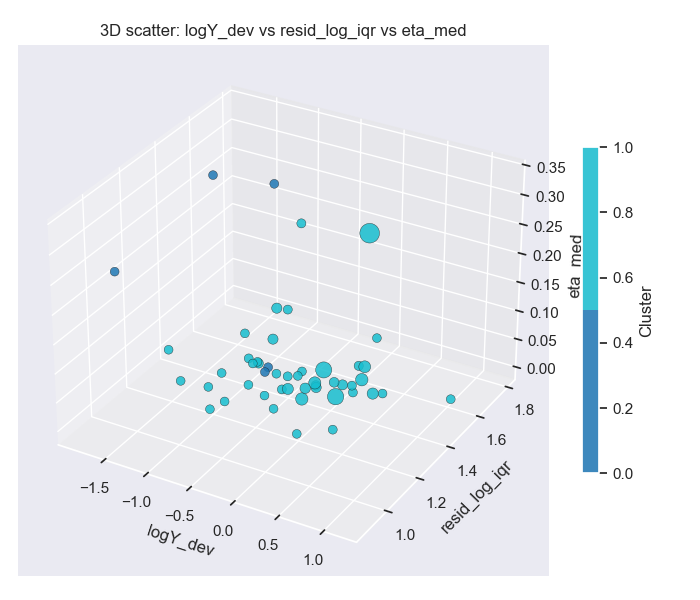

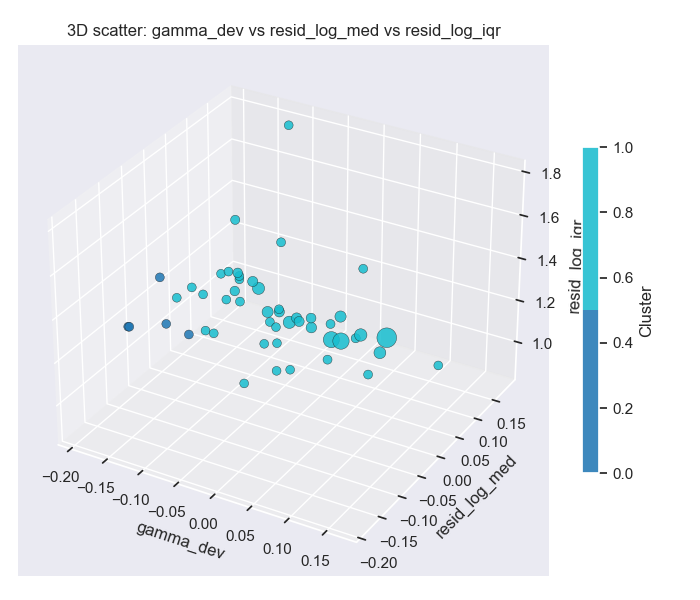

C:\Users\dinosse\AppData\Local\Temp\ipykernel_932\2777168731.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7, 6))


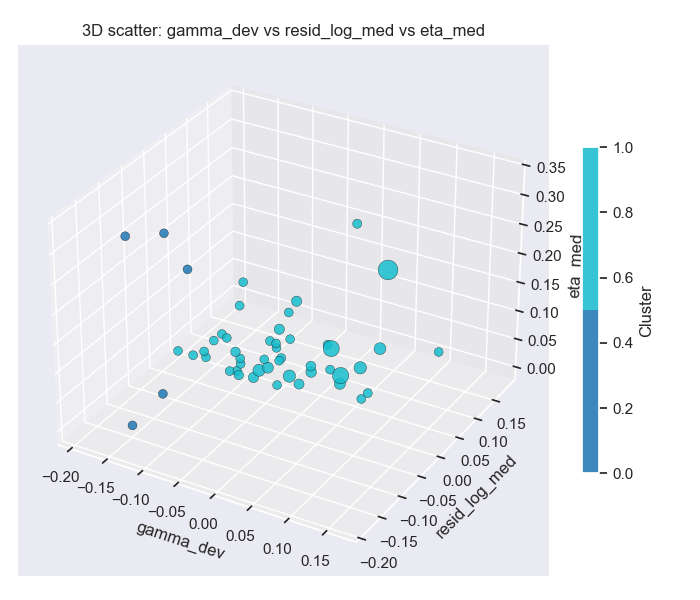

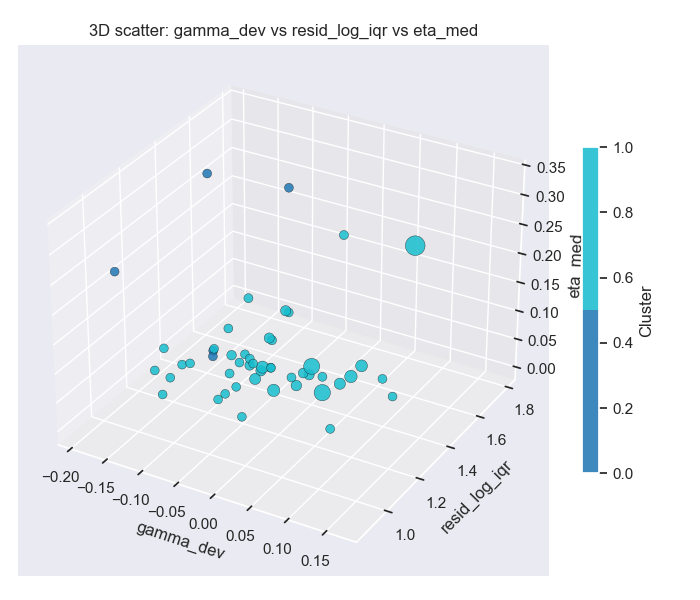

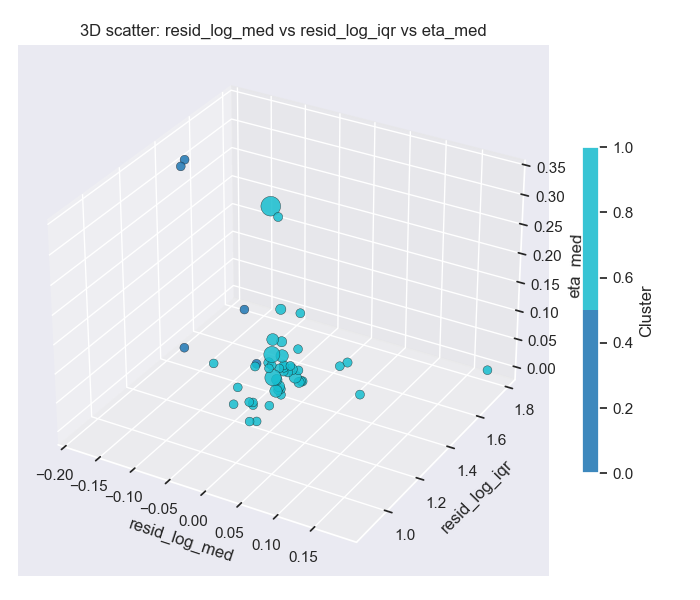

In [18]:
# 3D scatter plots for all combinations of three K-means input features
%matplotlib widget
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 -> needed for 3D projection

required_columns = set(feature_cols + ['cluster'])
if missing := [col for col in required_columns if col not in broker_metrics.columns]:
    raise RuntimeError(f"Missing columns in broker_metrics for 3D plots: {missing}")

feature_triplets = list(combinations(feature_cols, 3))
print(f"Number of feature triplets (combinations of 3 over {len(feature_cols)}): {len(feature_triplets)}")

clusters = broker_metrics['cluster'].to_numpy()
cluster_palette = plt.cm.get_cmap('tab10', len(np.unique(clusters)))
size_scale = broker_metrics['n_metaorders'] / broker_metrics['n_metaorders'].max()
marker_sizes = 40 + 160 * size_scale.fillna(0)

for triplet in feature_triplets:
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        broker_metrics[triplet[0]],
        broker_metrics[triplet[1]],
        broker_metrics[triplet[2]],
        c=clusters,
        cmap=cluster_palette,
        s=marker_sizes,
        alpha=0.85,
        edgecolors='k',
        linewidths=0.3,
    )
    ax.set_xlabel(triplet[0])
    ax.set_ylabel(triplet[1])
    ax.set_zlabel(triplet[2])
    ax.set_title(f'3D scatter: {triplet[0]} vs {triplet[1]} vs {triplet[2]}')
    plt.tight_layout()
    cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label('Cluster')
    plt.show()
